# Домашнее задание: Классификация 128x128 + U-Net c бэкбоном

In [14]:
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from collections import Counter
import zipfile
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import glob

# Установка seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


## Часть 1. Классификатор 128×128

### 1.1 Загрузка и подготовка данных Tiny ImageNet

In [27]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

URL transformed to HTTPS due to an HSTS policy
--2025-12-18 20:49:37--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  88.3MB/s    in 2.7s    

2025-12-18 20:49:40 (88.3 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]



In [3]:
!unzip -q tiny-imagenet-200.zip

In [15]:
SELECTED_CLASSES = ['n01443537', 'n01641577', 'n01698610', 'n01742172', 'n01882714', 'n02002724', 'n02056570', 'n02099601', 'n02123045']
print(f"Выбранные классы: {SELECTED_CLASSES}")

Выбранные классы: ['n01443537', 'n01641577', 'n01698610', 'n01742172', 'n01882714', 'n02002724', 'n02056570', 'n02099601', 'n02123045']


In [16]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, selected_classes, split='train', transform=None):
        """
        Args:
            root_dir: путь к корневой директории Tiny ImageNet
            selected_classes: список ID классов
            split: 'train' или 'val'
            transform: трансформации для изображений
        """
        self.root_dir = root_dir
        self.selected_classes = SELECTED_CLASSES
        self.split = split
        self.transform = transform

        # Маппинг класс -> индекс
        self.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

        # Инициализация путей к данным, загрузка списка изображений и меток
        self.image_paths = []
        self.labels = []

        if split == 'train':
            self._load_train_data()
        elif split == 'val':
            self._load_val_data()

    def _load_train_data(self):
        train_dir = os.path.join(self.root_dir, 'train')

        for class_id in self.selected_classes:
            class_dir = os.path.join(train_dir, class_id, 'images')
            image_files = glob.glob(os.path.join(class_dir, '*.JPEG'))

            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_id])

    def _load_val_data(self):
        val_dir = os.path.join(self.root_dir, 'val')
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                img_name = parts[0]
                class_id = parts[1]

                if class_id in self.selected_classes:
                    img_path = os.path.join(val_dir, 'images', img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_id])

    def __len__(self):
        """Возврат количества примеров в датасете"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Загрузка и возврат одного примера (изображение + метка)"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self):
        """Получение распределения классов"""
        return Counter(self.labels)

### 1.2 Архитектура модели классификатора

In [17]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet-style с residual connection
    """
    def __init__(self, in_channels, out_channels, stride=1, activation="relu"):
        super().__init__()

        # Первая свертка
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, padding=1,
            stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Вторая свертка
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Выбор функции активации
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "gelu":
            self.activation = nn.GELU()
        elif activation == "leakyrelu":
            self.activation = nn.LeakyReLU(inplace=True)
        else:
            self.activation = nn.ReLU(inplace=True)

        # Downsample при необходимости
        self.downsample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.activation(out)

        return out


class ResNetClassifier(nn.Module):
    """
    Кастомная ResNet-подобная архитектура для классификации
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # Энкодер с 4 уровнями
        self.block1 = BasicBlock(3, 32, activation="gelu")  # 128x128 -> 128x128
        self.block2 = BasicBlock(32, 64, stride=2, activation="gelu")  # 128x128 -> 64x64
        self.block3 = BasicBlock(64, 128, stride=2, activation="gelu")  # 64x64 -> 32x32
        self.block4 = BasicBlock(128, 256, stride=2, activation="gelu")  # 32x32 -> 16x16

        # Глобальное усреднение и классификатор
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        """Инициализация весов модели"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Энкодер
        x = self.block1(x)  # [B, 32, 128, 128]
        x = self.block2(x)  # [B, 64, 64, 64]
        x = self.block3(x)  # [B, 128, 32, 32]
        x = self.block4(x)  # [B, 256, 16, 16]

        # Глобальное усреднение
        x = self.gap(x)  # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 256]

        # Классификация
        x = self.fc(x)  # [B, num_classes]

        return x

    def get_encoder_features(self, x):
        """
        Получение признаков на разных уровнях энкодера
        (для использования в U-Net)
        """
        features = []

        x = self.block1(x)
        features.append(x)  # Level 1: [B, 32, 128, 128]

        x = self.block2(x)
        features.append(x)  # Level 2: [B, 64, 64, 64]

        x = self.block3(x)
        features.append(x)  # Level 3: [B, 128, 32, 32]

        x = self.block4(x)
        features.append(x)  # Level 4: [B, 256, 16, 16]

        return features

### 1.3 Подготовка данных для обучения

In [18]:
# Определение трансформаций
train_transform = transforms.Compose([
    transforms.Resize((136, 136)),  # Ресайз для последующего кропа
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop с аугментацией
    transforms.RandomHorizontalFlip(p=0.5),  # Горизонтальный флип
    transforms.RandomRotation(10),  # Случайный поворот
    transforms.ColorJitter(
        brightness=0.2,  # Яркость
        contrast=0.2,    # Контраст
        saturation=0.2,  # Насыщенность
        hue=0.1          # Оттенок
    ),
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Средние значения ImageNet
        std=[0.229, 0.224, 0.225]    # Стандартные отклонения ImageNet
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Фиксированный ресайз
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Загрузка датасетов
def load_tiny_imagenet(root_path="tiny-imagenet-200"):
    """Загрузка и подготовка Tiny ImageNet датасета"""

    # Проверка наличия данных
    if not os.path.exists(root_path):
        # Распаковка архива (если требуется)
        zip_path = f"{root_path}.zip"
        if os.path.exists(zip_path):
            print(f"Распаковка архива {zip_path}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
        else:
            raise FileNotFoundError(f"Файл {zip_path} не найден")

    # Создание датасетов
    train_dataset = TinyImageNetDataset(
        root_dir=root_path,
        selected_classes=SELECTED_CLASSES,
        split='train',
        transform=train_transform
    )

    val_dataset = TinyImageNetDataset(
        root_dir=root_path,
        selected_classes=SELECTED_CLASSES,
        split='val',
        transform=val_transform
    )

    print(f"Тренировочных изображений: {len(train_dataset)}")
    print(f"Валидационных изображений: {len(val_dataset)}")
    print(f"Количество классов: {len(SELECTED_CLASSES)}")

    # Проверка распределения классов
    train_dist = train_dataset.get_class_distribution()
    val_dist = val_dataset.get_class_distribution()

    print("\nРаспределение классов в train:")
    for cls, count in train_dist.items():
        print(f"  Класс {cls}: {count} изображений")

    print("\nРаспределение классов в val:")
    for cls, count in val_dist.items():
        print(f"  Класс {cls}: {count} изображений")

    return train_dataset, val_dataset

# Загрузка данных
train_dataset, val_dataset = load_tiny_imagenet()

# Создание DataLoader
BATCH_SIZE = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

Тренировочных изображений: 4000
Валидационных изображений: 400
Количество классов: 9

Распределение классов в train:
  Класс 0: 500 изображений
  Класс 1: 500 изображений
  Класс 3: 500 изображений
  Класс 4: 500 изображений
  Класс 5: 500 изображений
  Класс 6: 500 изображений
  Класс 7: 500 изображений
  Класс 8: 500 изображений

Распределение классов в val:
  Класс 6: 50 изображений
  Класс 0: 50 изображений
  Класс 3: 50 изображений
  Класс 8: 50 изображений
  Класс 5: 50 изображений
  Класс 1: 50 изображений
  Класс 7: 50 изображений
  Класс 4: 50 изображений


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 1.4 Функции для обучения и валидации

In [22]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Обучение модели на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Обновление прогресс-бара
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")

        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Статистика
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Сохранение предсказаний для метрик
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    # Дополнительные метрики
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    return epoch_loss, epoch_acc, precision, recall, f1


def train_classifier(model, train_loader, val_loader, num_epochs=40,
                     learning_rate=0.001, save_path="best_classifier.pth"):
    """Основная функция обучения классификатора"""

    model = model.to(device)

    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    criterion = nn.CrossEntropyLoss()

    # История обучения
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rate': []
    }

    best_val_acc = 0.0

    print(f"Начало обучения на {num_epochs} эпох...")
    print(f"Размер батча: {train_loader.batch_size}")
    print(f"Общее количество батчей в эпоху: {len(train_loader)}")

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        # Обучение
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_acc, val_precision, val_recall, val_f1 = validate_epoch(
            model, val_loader, criterion, device
        )

        # Обновление learning rate
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(current_lr)

        # Вывод результатов
        print(f"\nРезультаты эпохи {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Val Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_path)
            print(f"  ✓ Сохранена лучшая модель с точностью {val_acc:.2f}%")

    print(f"\n{'='*50}")
    print(f"Обучение завершено!")
    print(f"Лучшая точность на валидации: {best_val_acc:.2f}%")
    print(f"{'='*50}")

    return history, model

### 1.5 Обучение классификатора

In [23]:
# Создание модели
num_classes = len(SELECTED_CLASSES)
classifier = ResNetClassifier(num_classes=num_classes)

# Подсчет параметров
total_params = sum(p.numel() for p in classifier.parameters())
trainable_params = sum(p.numel() for p in classifier.parameters() if p.requires_grad)

print(f"Архитектура модели:")
print(f"  Всего параметров: {total_params:,}")
print(f"  Обучаемых параметров: {trainable_params:,}")
print(f"  Количество классов: {num_classes}")

# Проверка прямого прохода - ВАЖНО: перемещаем модель на устройство
classifier = classifier.to(device)  # <-- ДОБАВИТЬ ЭТУ СТРОКУ
test_input = torch.randn(2, 3, 128, 128).to(device)
test_output = classifier(test_input)
print(f"\nТестовый вход: {test_input.shape}")
print(f"Тестовый выход: {test_output.shape}")

# Обучение модели
history, trained_classifier = train_classifier(
    model=classifier,  # модель уже на device
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=40,
    learning_rate=0.001,
    save_path="best_classifier.pth"
)

Архитектура модели:
  Всего параметров: 1,219,593
  Обучаемых параметров: 1,219,593
  Количество классов: 9

Тестовый вход: torch.Size([2, 3, 128, 128])
Тестовый выход: torch.Size([2, 9])
Начало обучения на 40 эпох...
Размер батча: 64
Общее количество батчей в эпоху: 62

Эпоха 1/40


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.77it/s, loss=2.0416, acc=33.25%]



Результаты эпохи 1:
  Train Loss: 1.8125, Train Acc: 33.47%
  Val Loss: 1.8746, Val Acc: 33.25%
  Val Precision: 0.3556, Recall: 0.3325, F1: 0.3090
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 33.25%

Эпоха 2/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s, loss=1.9155, acc=41.25%]



Результаты эпохи 2:
  Train Loss: 1.6484, Train Acc: 39.64%
  Val Loss: 1.6017, Val Acc: 41.25%
  Val Precision: 0.4138, Recall: 0.4125, F1: 0.4014
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 41.25%

Эпоха 3/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  9.37it/s, loss=1.9308, acc=45.75%]



Результаты эпохи 3:
  Train Loss: 1.5269, Train Acc: 44.51%
  Val Loss: 1.5319, Val Acc: 45.75%
  Val Precision: 0.4683, Recall: 0.4575, F1: 0.4488
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 45.75%

Эпоха 4/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s, loss=1.7630, acc=47.00%]



Результаты эпохи 4:
  Train Loss: 1.4204, Train Acc: 49.75%
  Val Loss: 1.5027, Val Acc: 47.00%
  Val Precision: 0.4846, Recall: 0.4700, F1: 0.4648
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 47.00%

Эпоха 5/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s, loss=1.9411, acc=46.50%]



Результаты эпохи 5:
  Train Loss: 1.3271, Train Acc: 52.75%
  Val Loss: 1.5207, Val Acc: 46.50%
  Val Precision: 0.4925, Recall: 0.4650, F1: 0.4623
  Learning Rate: 0.001000

Эпоха 6/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s, loss=1.6799, acc=43.00%]



Результаты эпохи 6:
  Train Loss: 1.3072, Train Acc: 53.68%
  Val Loss: 1.4287, Val Acc: 43.00%
  Val Precision: 0.5096, Recall: 0.4300, F1: 0.4314
  Learning Rate: 0.001000

Эпоха 7/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.79it/s, loss=1.6739, acc=53.75%]



Результаты эпохи 7:
  Train Loss: 1.2440, Train Acc: 55.92%
  Val Loss: 1.3130, Val Acc: 53.75%
  Val Precision: 0.5800, Recall: 0.5375, F1: 0.5239
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 53.75%

Эпоха 8/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  7.85it/s, loss=1.7427, acc=54.00%]



Результаты эпохи 8:
  Train Loss: 1.2022, Train Acc: 58.54%
  Val Loss: 1.3154, Val Acc: 54.00%
  Val Precision: 0.5558, Recall: 0.5400, F1: 0.5316
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 54.00%

Эпоха 9/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s, loss=2.0300, acc=56.25%]



Результаты эпохи 9:
  Train Loss: 1.1757, Train Acc: 58.90%
  Val Loss: 1.3870, Val Acc: 56.25%
  Val Precision: 0.5938, Recall: 0.5625, F1: 0.5324
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 56.25%

Эпоха 10/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s, loss=1.5737, acc=54.00%]



Результаты эпохи 10:
  Train Loss: 1.1511, Train Acc: 60.61%
  Val Loss: 1.2703, Val Acc: 54.00%
  Val Precision: 0.5700, Recall: 0.5400, F1: 0.5464
  Learning Rate: 0.001000

Эпоха 11/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s, loss=1.6150, acc=54.50%]



Результаты эпохи 11:
  Train Loss: 1.0836, Train Acc: 61.62%
  Val Loss: 1.2575, Val Acc: 54.50%
  Val Precision: 0.6112, Recall: 0.5450, F1: 0.5420
  Learning Rate: 0.001000

Эпоха 12/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s, loss=1.7100, acc=59.00%]



Результаты эпохи 12:
  Train Loss: 1.0750, Train Acc: 62.70%
  Val Loss: 1.3121, Val Acc: 59.00%
  Val Precision: 0.5964, Recall: 0.5900, F1: 0.5901
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 59.00%

Эпоха 13/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  8.37it/s, loss=1.5652, acc=56.50%]



Результаты эпохи 13:
  Train Loss: 1.0319, Train Acc: 64.52%
  Val Loss: 1.2103, Val Acc: 56.50%
  Val Precision: 0.5925, Recall: 0.5650, F1: 0.5668
  Learning Rate: 0.001000

Эпоха 14/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.18it/s, loss=1.6941, acc=57.00%]



Результаты эпохи 14:
  Train Loss: 1.0169, Train Acc: 65.07%
  Val Loss: 1.1931, Val Acc: 57.00%
  Val Precision: 0.6179, Recall: 0.5700, F1: 0.5740
  Learning Rate: 0.001000

Эпоха 15/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s, loss=1.7759, acc=59.25%]



Результаты эпохи 15:
  Train Loss: 1.0000, Train Acc: 65.68%
  Val Loss: 1.2043, Val Acc: 59.25%
  Val Precision: 0.6246, Recall: 0.5925, F1: 0.5935
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 59.25%

Эпоха 16/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s, loss=1.5352, acc=63.75%]



Результаты эпохи 16:
  Train Loss: 0.9482, Train Acc: 67.94%
  Val Loss: 1.1130, Val Acc: 63.75%
  Val Precision: 0.6508, Recall: 0.6375, F1: 0.6366
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 63.75%

Эпоха 17/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s, loss=1.6833, acc=56.25%]



Результаты эпохи 17:
  Train Loss: 0.9467, Train Acc: 66.76%
  Val Loss: 1.2821, Val Acc: 56.25%
  Val Precision: 0.5992, Recall: 0.5625, F1: 0.5453
  Learning Rate: 0.001000

Эпоха 18/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s, loss=1.4395, acc=67.75%]



Результаты эпохи 18:
  Train Loss: 0.9093, Train Acc: 68.98%
  Val Loss: 1.0290, Val Acc: 67.75%
  Val Precision: 0.6864, Recall: 0.6775, F1: 0.6761
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 67.75%

Эпоха 19/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s, loss=1.8496, acc=56.25%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Результаты эпохи 19:
  Train Loss: 0.8926, Train Acc: 69.13%
  Val Loss: 1.4234, Val Acc: 56.25%
  Val Precision: 0.5318, Recall: 0.5625, F1: 0.5360
  Learning Rate: 0.001000

Эпоха 20/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s, loss=1.2199, acc=65.25%]



Результаты эпохи 20:
  Train Loss: 0.8969, Train Acc: 69.10%
  Val Loss: 1.0723, Val Acc: 65.25%
  Val Precision: 0.6528, Recall: 0.6525, F1: 0.6477
  Learning Rate: 0.001000

Эпоха 21/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s, loss=1.5944, acc=63.00%]



Результаты эпохи 21:
  Train Loss: 0.8798, Train Acc: 69.71%
  Val Loss: 1.1713, Val Acc: 63.00%
  Val Precision: 0.5953, Recall: 0.6300, F1: 0.6011
  Learning Rate: 0.001000

Эпоха 22/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 11.05it/s, loss=1.6851, acc=59.25%]



Результаты эпохи 22:
  Train Loss: 0.8185, Train Acc: 72.33%
  Val Loss: 1.2447, Val Acc: 59.25%
  Val Precision: 0.6740, Recall: 0.5925, F1: 0.5937
  Learning Rate: 0.001000

Эпоха 23/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s, loss=1.4941, acc=61.50%]



Результаты эпохи 23:
  Train Loss: 0.7961, Train Acc: 72.53%
  Val Loss: 1.1212, Val Acc: 61.50%
  Val Precision: 0.6578, Recall: 0.6150, F1: 0.6071
  Learning Rate: 0.001000

Эпоха 24/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s, loss=1.5061, acc=69.00%]



Результаты эпохи 24:
  Train Loss: 0.7791, Train Acc: 73.03%
  Val Loss: 1.0107, Val Acc: 69.00%
  Val Precision: 0.6930, Recall: 0.6900, F1: 0.6881
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 69.00%

Эпоха 25/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s, loss=1.1991, acc=64.50%]



Результаты эпохи 25:
  Train Loss: 0.7726, Train Acc: 74.17%
  Val Loss: 0.9994, Val Acc: 64.50%
  Val Precision: 0.6910, Recall: 0.6450, F1: 0.6519
  Learning Rate: 0.001000

Эпоха 26/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s, loss=2.1385, acc=62.25%]



Результаты эпохи 26:
  Train Loss: 0.7591, Train Acc: 73.56%
  Val Loss: 1.2373, Val Acc: 62.25%
  Val Precision: 0.7082, Recall: 0.6225, F1: 0.6300
  Learning Rate: 0.001000

Эпоха 27/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s, loss=1.6252, acc=66.00%]



Результаты эпохи 27:
  Train Loss: 0.7389, Train Acc: 75.23%
  Val Loss: 1.0634, Val Acc: 66.00%
  Val Precision: 0.6479, Recall: 0.6600, F1: 0.6404
  Learning Rate: 0.001000

Эпоха 28/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.71it/s, loss=1.4036, acc=69.75%]



Результаты эпохи 28:
  Train Loss: 0.7326, Train Acc: 75.30%
  Val Loss: 0.9535, Val Acc: 69.75%
  Val Precision: 0.7399, Recall: 0.6975, F1: 0.6973
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 69.75%

Эпоха 29/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.67it/s, loss=1.6014, acc=69.75%]



Результаты эпохи 29:
  Train Loss: 0.7098, Train Acc: 75.73%
  Val Loss: 0.9339, Val Acc: 69.75%
  Val Precision: 0.6979, Recall: 0.6975, F1: 0.6959
  Learning Rate: 0.001000

Эпоха 30/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.58it/s, loss=1.3236, acc=67.00%]



Результаты эпохи 30:
  Train Loss: 0.6854, Train Acc: 76.61%
  Val Loss: 0.9661, Val Acc: 67.00%
  Val Precision: 0.6935, Recall: 0.6700, F1: 0.6559
  Learning Rate: 0.001000

Эпоха 31/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  9.55it/s, loss=1.3720, acc=69.50%]



Результаты эпохи 31:
  Train Loss: 0.6489, Train Acc: 78.48%
  Val Loss: 1.0143, Val Acc: 69.50%
  Val Precision: 0.7025, Recall: 0.6950, F1: 0.6864
  Learning Rate: 0.001000

Эпоха 32/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s, loss=1.7590, acc=66.50%]



Результаты эпохи 32:
  Train Loss: 0.6716, Train Acc: 77.62%
  Val Loss: 1.0545, Val Acc: 66.50%
  Val Precision: 0.6763, Recall: 0.6650, F1: 0.6632
  Learning Rate: 0.001000

Эпоха 33/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s, loss=1.8812, acc=65.00%]



Результаты эпохи 33:
  Train Loss: 0.6669, Train Acc: 77.37%
  Val Loss: 1.0778, Val Acc: 65.00%
  Val Precision: 0.6928, Recall: 0.6500, F1: 0.6475
  Learning Rate: 0.001000

Эпоха 34/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s, loss=1.5982, acc=70.25%]



Результаты эпохи 34:
  Train Loss: 0.6391, Train Acc: 78.15%
  Val Loss: 1.0276, Val Acc: 70.25%
  Val Precision: 0.7166, Recall: 0.7025, F1: 0.6975
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 70.25%

Эпоха 35/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s, loss=1.6437, acc=69.75%]



Результаты эпохи 35:
  Train Loss: 0.6429, Train Acc: 78.12%
  Val Loss: 0.9662, Val Acc: 69.75%
  Val Precision: 0.7319, Recall: 0.6975, F1: 0.6953
  Learning Rate: 0.001000

Эпоха 36/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s, loss=1.7630, acc=70.75%]



Результаты эпохи 36:
  Train Loss: 0.6152, Train Acc: 79.11%
  Val Loss: 1.0355, Val Acc: 70.75%
  Val Precision: 0.7353, Recall: 0.7075, F1: 0.7088
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 70.75%

Эпоха 37/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s, loss=1.7036, acc=70.50%]



Результаты эпохи 37:
  Train Loss: 0.6262, Train Acc: 78.98%
  Val Loss: 1.0838, Val Acc: 70.50%
  Val Precision: 0.7452, Recall: 0.7050, F1: 0.7067
  Learning Rate: 0.001000

Эпоха 38/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.78it/s, loss=2.0579, acc=63.00%]



Результаты эпохи 38:
  Train Loss: 0.6170, Train Acc: 79.33%
  Val Loss: 1.2379, Val Acc: 63.00%
  Val Precision: 0.6815, Recall: 0.6300, F1: 0.6289
  Learning Rate: 0.001000

Эпоха 39/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.89it/s, loss=1.6621, acc=71.75%]



Результаты эпохи 39:
  Train Loss: 0.5843, Train Acc: 80.49%
  Val Loss: 0.9400, Val Acc: 71.75%
  Val Precision: 0.7358, Recall: 0.7175, F1: 0.7201
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 71.75%

Эпоха 40/40


Training:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 7/7 [00:00<00:00, 10.74it/s, loss=1.7438, acc=72.25%]



Результаты эпохи 40:
  Train Loss: 0.5472, Train Acc: 82.23%
  Val Loss: 0.9211, Val Acc: 72.25%
  Val Precision: 0.7663, Recall: 0.7225, F1: 0.7300
  Learning Rate: 0.001000
  ✓ Сохранена лучшая модель с точностью 72.25%

Обучение завершено!
Лучшая точность на валидации: 72.25%


### 1.6 Визуализация результатов обучения классификатора

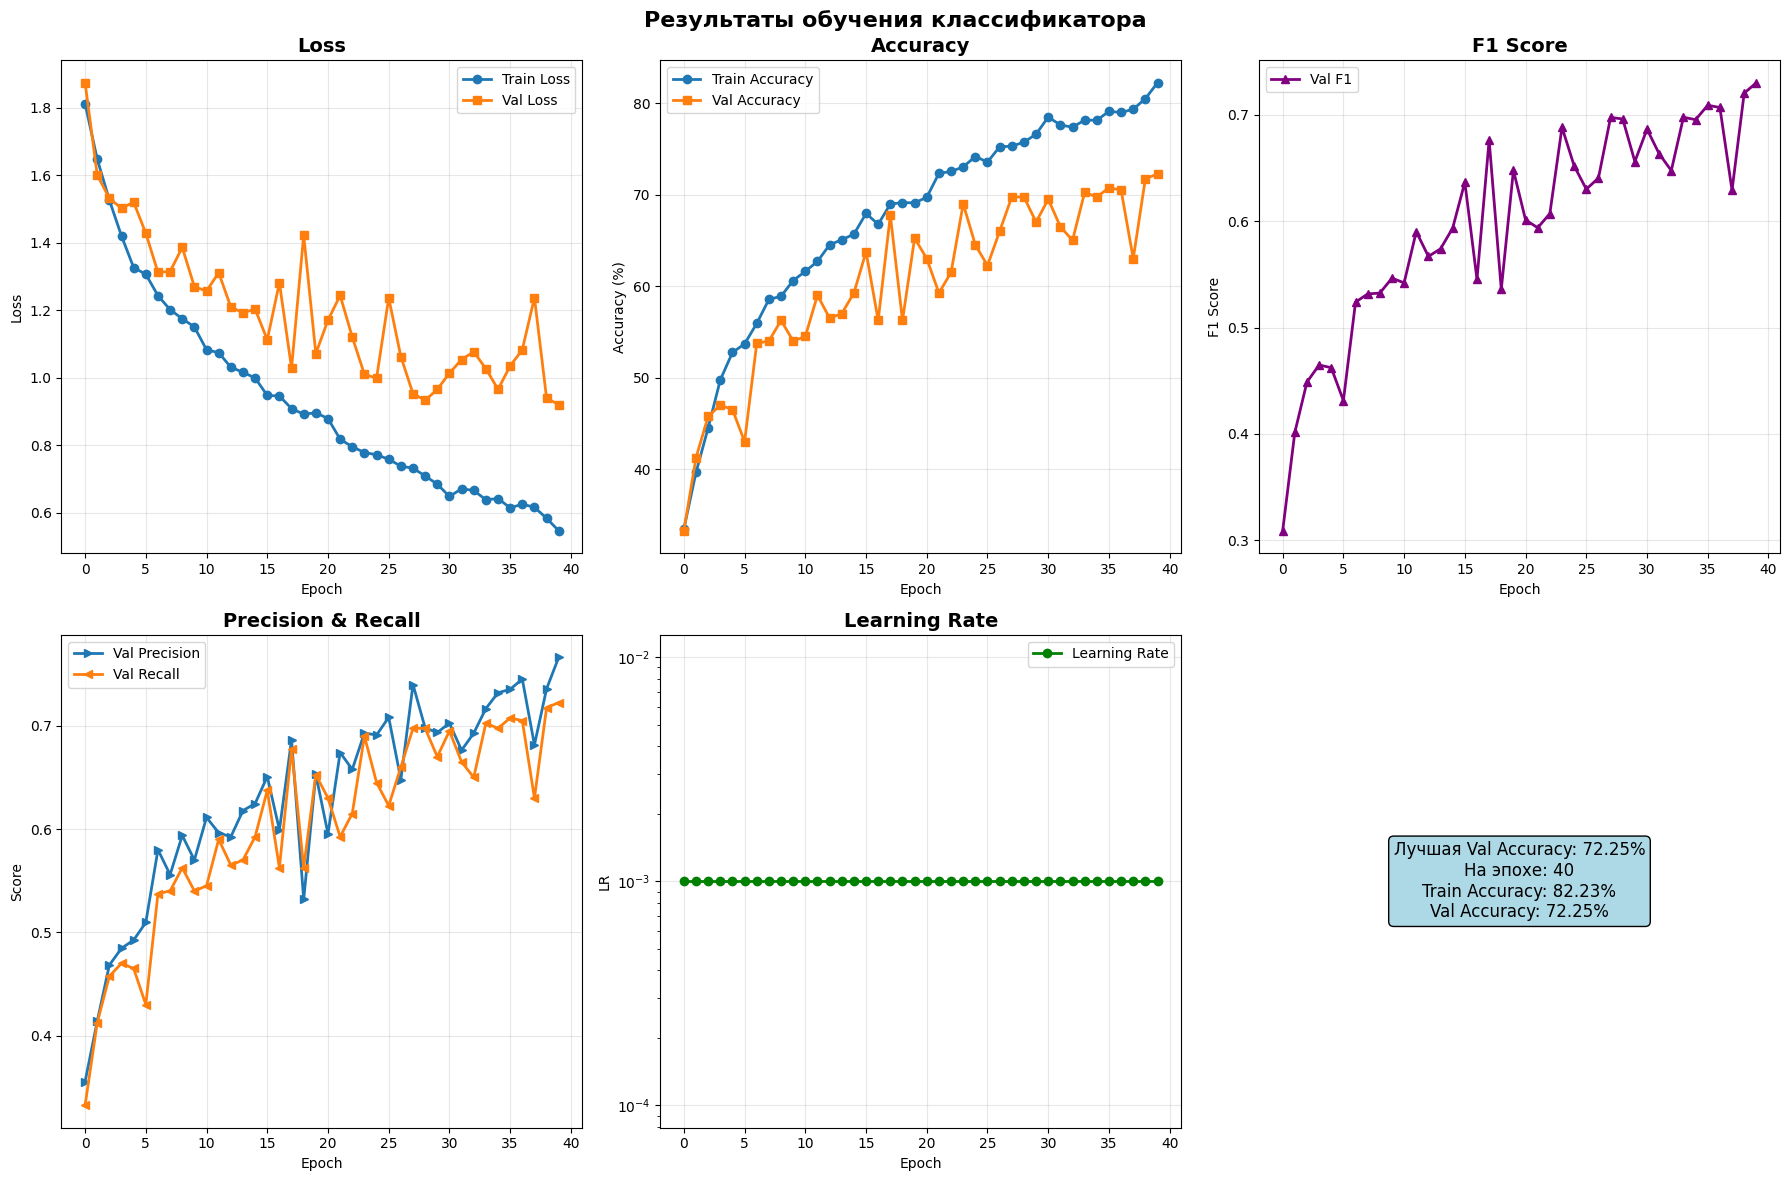

In [25]:
def plot_classifier_training_history(history):
    """Визуализация истории обучения классификатора"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 Score
    axes[0, 2].plot(history['val_f1'], label='Val F1', marker='^', linewidth=2, color='purple')
    axes[0, 2].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Precision и Recall
    axes[1, 0].plot(history['val_precision'], label='Val Precision', marker='>', linewidth=2)
    axes[1, 0].plot(history['val_recall'], label='Val Recall', marker='<', linewidth=2)
    axes[1, 0].set_title('Precision & Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['learning_rate'], label='Learning Rate',
                   marker='o', linewidth=2, color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Confusion Matrix (последняя эпоха)
    axes[1, 2].axis('off')
    axes[1, 2].text(0.5, 0.5,
                   f"Лучшая Val Accuracy: {max(history['val_acc']):.2f}%\n"
                   f"На эпохе: {history['val_acc'].index(max(history['val_acc'])) + 1}\n"
                   f"Train Accuracy: {history['train_acc'][-1]:.2f}%\n"
                   f"Val Accuracy: {history['val_acc'][-1]:.2f}%",
                   ha='center', va='center', fontsize=12,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.suptitle('Результаты обучения классификатора', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Визуализация
plot_classifier_training_history(history)

Лучшая точность на валидации: 72.25% на последней эпохе

## Часть 2. Базовая U-Net на "Луне"

### 2.1 Загрузка и подготовка данных сегментации

In [38]:
class MoonSegmentationDataset(Dataset):
    """Датасет для бинарной сегментации лунной поверхности"""

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)

        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '')
                            for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Загрузка изображения
        image_path = os.path.join(self.root_dir, 'images',
                                self.image_folder, f"{image_id}.png")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Загрузка маски
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images',
                               self.mask_folder, f"ground{mask_id}.png")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Нормализация маски к [0, 1]
        mask = (mask > 0).astype(np.float32)

        # Применение аугментаций
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Применение предобработки
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask)
            image, mask = preprocessed['image'], preprocessed['mask']

        return image, mask


def load_moon_segmentation_data(data_root="MOON_SEGMENTATION_BINARY"):
    """Загрузка и подготовка данных для сегментации"""

    # Проверка наличия данных
    if not os.path.exists(data_root):
        zip_path = f"{data_root}.zip"
        if os.path.exists(zip_path):
            print(f"Распаковка архива {zip_path}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
        else:
            raise FileNotFoundError(f"Файл {zip_path} не найден")

    # Получение списка изображений
    images_dir = os.path.join(data_root, 'images', 'render')
    all_images = [img.replace('.png', '')
                 for img in os.listdir(images_dir) if img.endswith('.png')][:100]

    print(f"Всего изображений: {len(all_images)}")

    # Разделение на train/val
    train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

    print(f"Train изображений: {len(train_ids)}")
    print(f"Val изображений: {len(val_ids)}")

    # Определение аугментаций
    train_augmentation = A.Compose([
        A.Resize(128, 128),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7)),
            A.MedianBlur(blur_limit=5),
        ], p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ])

    val_augmentation = A.Compose([
        A.Resize(128, 128),
    ])

    # Предобработка
    preprocessing = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406),
                   std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    # Создание датасетов
    train_dataset = MoonSegmentationDataset(
        root_dir=data_root,
        image_folder='render',
        mask_folder='ground',
        image_ids=train_ids,
        augmentation=train_augmentation,
        preprocessing=preprocessing
    )

    val_dataset = MoonSegmentationDataset(
        root_dir=data_root,
        image_folder='render',
        mask_folder='ground',
        image_ids=val_ids,
        augmentation=val_augmentation,
        preprocessing=preprocessing
    )

    return train_dataset, val_dataset


# Загрузка данных
train_dataset, val_dataset = load_moon_segmentation_data()

# Создание DataLoader для сегментации
BATCH_SIZE_SEG = 4
NUM_WORKERS_SEG = 2

train_loader_seg = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_SEG,
    shuffle=True,
    num_workers=NUM_WORKERS_SEG,
    pin_memory=True,
    drop_last=True
)

val_loader_seg = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE_SEG,
    shuffle=False,
    num_workers=NUM_WORKERS_SEG,
    pin_memory=True,
    drop_last=False
)

print(f"\nDataLoader для сегментации:")
print(f"  Batch size: {BATCH_SIZE_SEG}")
print(f"  Train батчей: {len(train_loader_seg)}")
print(f"  Val батчей: {len(val_loader_seg)}")

Распаковка архива MOON_SEGMENTATION_BINARY.zip...
Всего изображений: 100
Train изображений: 80
Val изображений: 20

DataLoader для сегментации:
  Batch size: 4
  Train батчей: 20
  Val батчей: 5


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### 2.2 Архитектура базовой U-Net

In [42]:
class DoubleConv(nn.Module):
    """Двойная сверточная блок для U-Net"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Базовая U-Net архитектура для бинарной сегментации"""

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()

        # Encoder (downsampling path)
        self.enc1 = DoubleConv(in_channels, features[0])
        self.enc2 = DoubleConv(features[0], features[1])
        self.enc3 = DoubleConv(features[1], features[2])
        self.enc4 = DoubleConv(features[2], features[3])

        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[3], features[3] * 2)

        # Decoder (upsampling path)
        self.upconv4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3] * 2, features[3])

        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2])

        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1])

        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0])

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

        # Подсчет параметров
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Архитектура U-Net:")
        print(f"  Всего параметров: {total_params:,}")
        print(f"  Конфигурация каналов: {features}")
        print(f"  Размеры: 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128")

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # [B, 32, 128, 128]
        e2 = self.enc2(self.pool(e1))  # [B, 64, 64, 64]
        e3 = self.enc3(self.pool(e2))  # [B, 128, 32, 32]
        e4 = self.enc4(self.pool(e3))  # [B, 256, 16, 16]

        # Bottleneck
        b = self.bottleneck(self.pool(e4))  # [B, 512, 8, 8]

        # Decoder с skip connections
        d4 = self.upconv4(b)  # [B, 256, 16, 16]
        d4 = torch.cat([e4, d4], dim=1)  # [B, 512, 16, 16]
        d4 = self.dec4(d4)  # [B, 256, 16, 16]

        d3 = self.upconv3(d4)  # [B, 128, 32, 32]
        d3 = torch.cat([e3, d3], dim=1)  # [B, 256, 32, 32]
        d3 = self.dec3(d3)  # [B, 128, 32, 32]

        d2 = self.upconv2(d3)  # [B, 64, 64, 64]
        d2 = torch.cat([e2, d2], dim=1)  # [B, 128, 64, 64]
        d2 = self.dec2(d2)  # [B, 64, 64, 64]

        d1 = self.upconv1(d2)  # [B, 32, 128, 128]
        d1 = torch.cat([e1, d1], dim=1)  # [B, 64, 128, 128]
        d1 = self.dec1(d1)  # [B, 32, 128, 128]

        # Final output
        output = torch.sigmoid(self.final_conv(d1))  # [B, 1, 128, 128]

        return output


# Тестируем разные конфигурации
print("Тест 1: Стандартная конфигурация [32, 64, 128, 256]")
unet_model1 = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])
test_input = torch.randn(1, 3, 128, 128)
test_output = unet_model1(test_input)
print(f"  Вход: {test_input.shape}")
print(f"  Выход: {test_output.shape}")
print(f"  Параметров: {sum(p.numel() for p in unet_model1.parameters()):,}")

print("\nТест 2: Минимальная конфигурация [16, 32, 64, 128]")
unet_model2 = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])
test_output2 = unet_model2(test_input)
print(f"  Вход: {test_input.shape}")
print(f"  Выход: {test_output2.shape}")
print(f"  Параметров: {sum(p.numel() for p in unet_model2.parameters()):,}")

print("\nТест 3: Оригинальная [32, 64, 128, 192]")
unet_model3 = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])
test_output3 = unet_model3(test_input)
print(f"  Вход: {test_input.shape}")
print(f"  Выход: {test_output3.shape}")
print(f"  Параметров: {sum(p.numel() for p in unet_model3.parameters()):,}")

# Выбираем подходящую модель
print("\n" + "="*60)
print("ВЫБОР МОДЕЛИ ДЛЯ ОБУЧЕНИЯ")
print("="*60)

# Для соответствия требованию ~2.5M параметров выбираем [32, 64, 128, 192]
unet_model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])
total_params = sum(p.numel() for p in unet_model.parameters())

print(f"\nВыбрана модель с конфигурацией [32, 64, 128, 192]")
print(f"Количество параметров: {total_params:,}")
print(f"Соответствует требованию: {'Да' if total_params <= 2500000 else 'Нет'}")

# Информация о размерах
print("\nДетализация размеров:")
test_batch = torch.randn(2, 3, 128, 128)
output = unet_model(test_batch)
print(f"Входной батч: {test_batch.shape}")
print(f"Выходной батч: {output.shape}")
print(f"Min значение выхода: {output.min().item():.4f}")
print(f"Max значение выхода: {output.max().item():.4f}")
print(f"Mean значение выхода: {output.mean().item():.4f}")

# Проверяем, что выход в правильном диапазоне [0, 1] благодаря sigmoid
assert output.min() >= 0 and output.max() <= 1, "Выход не в диапазоне [0, 1]"
print("Модель работает корректно")

Тест 1: Стандартная конфигурация [32, 64, 128, 256]
Архитектура U-Net:
  Всего параметров: 7,763,041
  Конфигурация каналов: [32, 64, 128, 256]
  Размеры: 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128
  Вход: torch.Size([1, 3, 128, 128])
  Выход: torch.Size([1, 1, 128, 128])
  Параметров: 7,763,041

Тест 2: Минимальная конфигурация [16, 32, 64, 128]
Архитектура U-Net:
  Всего параметров: 1,942,577
  Конфигурация каналов: [16, 32, 64, 128]
  Размеры: 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128
  Вход: torch.Size([1, 3, 128, 128])
  Выход: torch.Size([1, 1, 128, 128])
  Параметров: 1,942,577

Тест 3: Оригинальная [32, 64, 128, 192]
Архитектура U-Net:
  Всего параметров: 4,845,601
  Конфигурация каналов: [32, 64, 128, 192]
  Размеры: 128x128 -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128
  Вход: torch.Size([1, 3, 128, 128])
  Выход: torch.Size([1, 1, 128, 128])
  Параметров: 4,845,601

ВЫБОР МОД

[32,64,128,192] (4.85M) — "золотая середина": достаточно глубины для извлечения признаков, но не чрезмерно.
Конфигурация сохраняет классическую прогрессию U-Net (удвоение каналов на каждом уровне), что важно для эффективного downsampling/upsampling.

### 2.3 Функции потерь и метрики для сегментации

In [43]:
class DiceLoss(nn.Module):
    """Dice Loss для бинарной сегментации"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)

        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / \
               (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):
    """Комбинированная функция потерь (BCE + Dice)"""
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    """Вычисление Dice coefficient"""
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / \
           (predictions.sum() + targets.sum() + smooth)

    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    """Вычисление IoU (Intersection over Union)"""
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    """Вычисление точности на уровне пикселей"""
    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

### 2.4 Функции обучения для сегментации

In [45]:
def train_segmentation_epoch(model, dataloader, criterion, optimizer, device):
    """Обучение модели сегментации на одной эпохе"""
    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(dataloader, desc="Training")

    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)  # [B, 1, H, W]

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Обратный проход
        loss.backward()
        optimizer.step()

        # Вычисление метрик
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        # Статистика
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        # Обновление прогресс-бара
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_iou = running_iou / len(dataloader)

    return epoch_loss, epoch_dice, epoch_iou


def validate_segmentation_epoch(model, dataloader, criterion, device):
    """Валидация модели сегментации"""
    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")

        for batch_idx, (images, masks) in enumerate(pbar):
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Вычисление метрик
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            # Статистика
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_dice, epoch_iou, epoch_acc


def train_segmentation_model(model, train_loader, val_loader, num_epochs=60,
                            learning_rate=1e-4, save_path="best_unet.pth"):
    """Основная функция обучения модели сегментации"""

    model = model.to(device)

    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

    # История обучения
    history = {
        'train_loss': [], 'train_dice': [], 'train_iou': [],
        'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_acc': [],
        'learning_rate': []
    }

    best_val_dice = 0.0

    print(f"Начало обучения сегментации на {num_epochs} эпох...")
    print(f"Размер батча: {train_loader.batch_size}")
    print(f"Общее количество батчей в эпоху: {len(train_loader)}")

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        # Обучение
        train_loss, train_dice, train_iou = train_segmentation_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_dice, val_iou, val_acc = validate_segmentation_epoch(
            model, val_loader, criterion, device
        )

        # Обновление learning rate
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        # Вывод результатов
        print(f"\nРезультаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Сохранение лучшей модели
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
                'val_acc': val_acc,
            }, save_path)
            print(f"Сохранена лучшая модель с Dice: {val_dice:.4f}")

    print(f"\n{'='*50}")
    print(f"Обучение завершено")
    print(f"Лучший Dice на валидации: {best_val_dice:.4f}")
    print(f"{'='*50}")

    return history, model


# Обучение базовой U-Net
history_unet, trained_unet = train_segmentation_model(
    model=unet_model,
    train_loader=train_loader_seg,
    val_loader=val_loader_seg,
    num_epochs=60,
    learning_rate=1e-4,
    save_path="best_unet.pth"
)

Начало обучения сегментации на 60 эпох...
Размер батча: 4
Общее количество батчей в эпоху: 20

Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s, loss=0.8519, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 1:
  Train - Loss: 0.8412, Dice: 0.1671, IoU: 0.0927
  Val - Loss: 0.8011, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100
Сохранена лучшая модель с Dice: 0.2381

Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s, loss=0.8438, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 2:
  Train - Loss: 0.8374, Dice: 0.1688, IoU: 0.0935
  Val - Loss: 0.7962, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s, loss=0.8427, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 3:
  Train - Loss: 0.8361, Dice: 0.1683, IoU: 0.0940
  Val - Loss: 0.7955, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.56it/s, loss=0.8429, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 4:
  Train - Loss: 0.8383, Dice: 0.1630, IoU: 0.0911
  Val - Loss: 0.7956, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s, loss=0.8384, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 5:
  Train - Loss: 0.8370, Dice: 0.1643, IoU: 0.0924
  Val - Loss: 0.7919, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s, loss=0.8408, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 6:
  Train - Loss: 0.8319, Dice: 0.1681, IoU: 0.0932
  Val - Loss: 0.7948, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s, loss=0.8371, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 7:
  Train - Loss: 0.8327, Dice: 0.1668, IoU: 0.0928
  Val - Loss: 0.7909, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s, loss=0.8371, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 8:
  Train - Loss: 0.8316, Dice: 0.1664, IoU: 0.0931
  Val - Loss: 0.7904, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s, loss=0.8357, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 9:
  Train - Loss: 0.8284, Dice: 0.1691, IoU: 0.0946
  Val - Loss: 0.7882, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.53it/s, loss=0.8335, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 10:
  Train - Loss: 0.8300, Dice: 0.1657, IoU: 0.0919
  Val - Loss: 0.7879, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.74it/s, loss=0.8336, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 11:
  Train - Loss: 0.8283, Dice: 0.1682, IoU: 0.0938
  Val - Loss: 0.7872, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s, loss=0.8342, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 12:
  Train - Loss: 0.8285, Dice: 0.1673, IoU: 0.0932
  Val - Loss: 0.7880, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s, loss=0.8333, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 13:
  Train - Loss: 0.8291, Dice: 0.1670, IoU: 0.0944
  Val - Loss: 0.7868, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s, loss=0.8335, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 14:
  Train - Loss: 0.8289, Dice: 0.1658, IoU: 0.0921
  Val - Loss: 0.7875, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s, loss=0.8349, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 15:
  Train - Loss: 0.8261, Dice: 0.1689, IoU: 0.0941
  Val - Loss: 0.7869, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s, loss=0.8328, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 16:
  Train - Loss: 0.8249, Dice: 0.1697, IoU: 0.0944
  Val - Loss: 0.7854, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s, loss=0.8311, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 17:
  Train - Loss: 0.8250, Dice: 0.1693, IoU: 0.0945
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s, loss=0.8319, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 18:
  Train - Loss: 0.8265, Dice: 0.1677, IoU: 0.0936
  Val - Loss: 0.7850, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s, loss=0.8333, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 19:
  Train - Loss: 0.8272, Dice: 0.1660, IoU: 0.0926
  Val - Loss: 0.7852, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.43it/s, loss=0.8305, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 20:
  Train - Loss: 0.8264, Dice: 0.1685, IoU: 0.0942
  Val - Loss: 0.7840, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s, loss=0.8315, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 21:
  Train - Loss: 0.8252, Dice: 0.1690, IoU: 0.0939
  Val - Loss: 0.7847, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.81it/s, loss=0.8312, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 22:
  Train - Loss: 0.8270, Dice: 0.1659, IoU: 0.0918
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.87it/s, loss=0.8325, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 23:
  Train - Loss: 0.8270, Dice: 0.1670, IoU: 0.0936
  Val - Loss: 0.7849, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s, loss=0.8336, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 24:
  Train - Loss: 0.8246, Dice: 0.1701, IoU: 0.0949
  Val - Loss: 0.7860, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s, loss=0.8302, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 25:
  Train - Loss: 0.8254, Dice: 0.1677, IoU: 0.0931
  Val - Loss: 0.7843, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s, loss=0.8333, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 26:
  Train - Loss: 0.8280, Dice: 0.1647, IoU: 0.0927
  Val - Loss: 0.7856, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s, loss=0.8319, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 27:
  Train - Loss: 0.8245, Dice: 0.1683, IoU: 0.0937
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s, loss=0.8313, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 28:
  Train - Loss: 0.8259, Dice: 0.1664, IoU: 0.0916
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.17it/s, loss=0.8314, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 29:
  Train - Loss: 0.8261, Dice: 0.1682, IoU: 0.0934
  Val - Loss: 0.7842, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.12it/s, loss=0.8314, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 30:
  Train - Loss: 0.8257, Dice: 0.1668, IoU: 0.0924
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s, loss=0.8327, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 31:
  Train - Loss: 0.8262, Dice: 0.1667, IoU: 0.0929
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.14it/s, loss=0.8324, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 32:
  Train - Loss: 0.8262, Dice: 0.1663, IoU: 0.0925
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s, loss=0.8315, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 33:
  Train - Loss: 0.8269, Dice: 0.1674, IoU: 0.0931
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.8313, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 34:
  Train - Loss: 0.8254, Dice: 0.1679, IoU: 0.0934
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s, loss=0.8308, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 35:
  Train - Loss: 0.8267, Dice: 0.1671, IoU: 0.0933
  Val - Loss: 0.7841, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s, loss=0.8308, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 36:
  Train - Loss: 0.8257, Dice: 0.1677, IoU: 0.0933
  Val - Loss: 0.7836, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s, loss=0.8294, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 37:
  Train - Loss: 0.8274, Dice: 0.1664, IoU: 0.0931
  Val - Loss: 0.7833, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.67it/s, loss=0.8297, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 38:
  Train - Loss: 0.8274, Dice: 0.1662, IoU: 0.0927
  Val - Loss: 0.7832, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.94it/s, loss=0.8316, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 39:
  Train - Loss: 0.8243, Dice: 0.1699, IoU: 0.0946
  Val - Loss: 0.7846, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s, loss=0.8310, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 40:
  Train - Loss: 0.8271, Dice: 0.1661, IoU: 0.0923
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s, loss=0.8322, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 41:
  Train - Loss: 0.8272, Dice: 0.1661, IoU: 0.0930
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s, loss=0.8312, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 42:
  Train - Loss: 0.8273, Dice: 0.1672, IoU: 0.0932
  Val - Loss: 0.7846, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s, loss=0.8318, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 43:
  Train - Loss: 0.8271, Dice: 0.1655, IoU: 0.0924
  Val - Loss: 0.7847, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s, loss=0.8329, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 44:
  Train - Loss: 0.8260, Dice: 0.1684, IoU: 0.0942
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s, loss=0.8314, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 45:
  Train - Loss: 0.8270, Dice: 0.1675, IoU: 0.0947
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.26it/s, loss=0.8325, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 46:
  Train - Loss: 0.8275, Dice: 0.1648, IoU: 0.0925
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.24it/s, loss=0.8312, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 47:
  Train - Loss: 0.8262, Dice: 0.1678, IoU: 0.0933
  Val - Loss: 0.7842, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s, loss=0.8311, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 48:
  Train - Loss: 0.8270, Dice: 0.1665, IoU: 0.0940
  Val - Loss: 0.7842, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s, loss=0.8313, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 49:
  Train - Loss: 0.8232, Dice: 0.1712, IoU: 0.0952
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.20it/s, loss=0.8311, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 50:
  Train - Loss: 0.8262, Dice: 0.1686, IoU: 0.0940
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s, loss=0.8304, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 51:
  Train - Loss: 0.8278, Dice: 0.1654, IoU: 0.0923
  Val - Loss: 0.7838, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.75it/s, loss=0.8312, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 52:
  Train - Loss: 0.8246, Dice: 0.1688, IoU: 0.0943
  Val - Loss: 0.7844, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s, loss=0.8302, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 53:
  Train - Loss: 0.8254, Dice: 0.1685, IoU: 0.0935
  Val - Loss: 0.7841, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.42it/s, loss=0.8314, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 54:
  Train - Loss: 0.8277, Dice: 0.1651, IoU: 0.0914
  Val - Loss: 0.7845, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=0.8323, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 55:
  Train - Loss: 0.8239, Dice: 0.1698, IoU: 0.0946
  Val - Loss: 0.7849, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s, loss=0.8303, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 56:
  Train - Loss: 0.8261, Dice: 0.1676, IoU: 0.0933
  Val - Loss: 0.7838, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s, loss=0.8298, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 57:
  Train - Loss: 0.8239, Dice: 0.1694, IoU: 0.0945
  Val - Loss: 0.7837, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.15it/s, loss=0.8318, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 58:
  Train - Loss: 0.8257, Dice: 0.1665, IoU: 0.0923
  Val - Loss: 0.7851, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s, loss=0.8316, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 59:
  Train - Loss: 0.8254, Dice: 0.1685, IoU: 0.0941
  Val - Loss: 0.7849, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.47it/s, loss=0.8323, dice=0.1625, iou=0.0884, acc=0.0884]


Результаты эпохи 60:
  Train - Loss: 0.8250, Dice: 0.1678, IoU: 0.0927
  Val - Loss: 0.7848, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Обучение завершено
Лучший Dice на валидации: 0.2381


### 2.5 Визуализация результатов сегментации

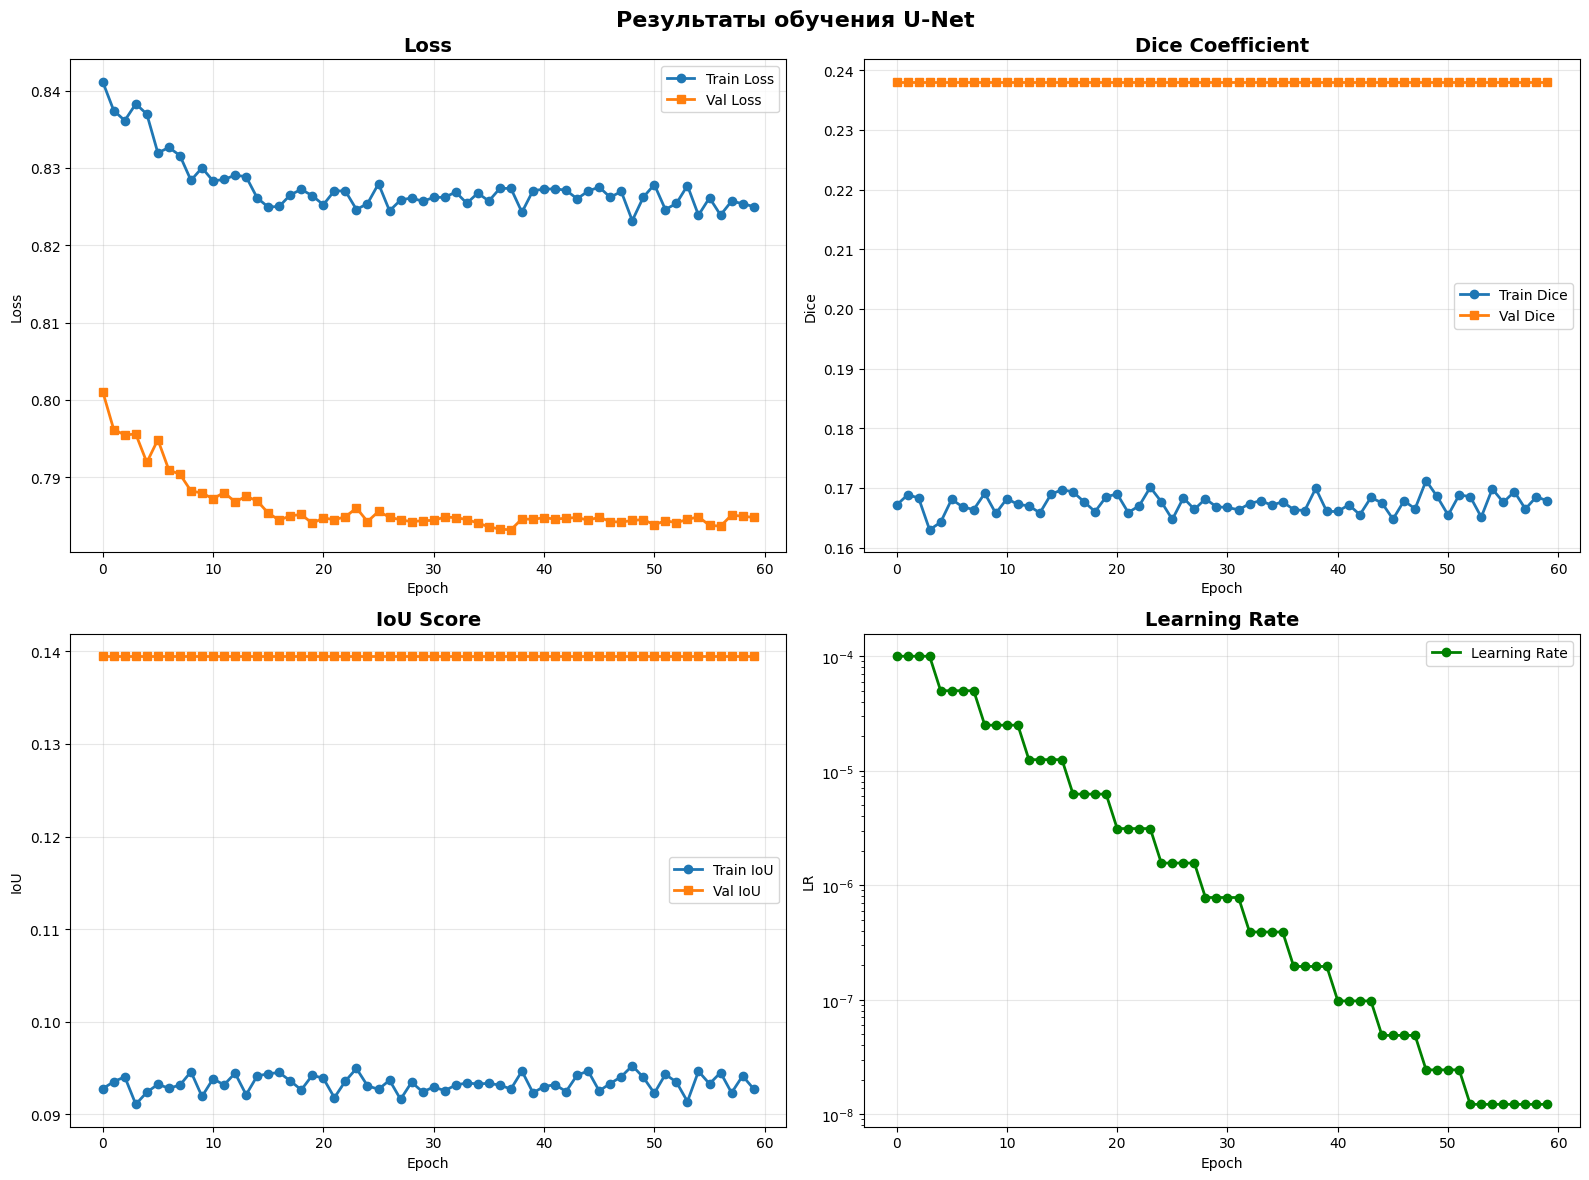

Итоговые метрики обучения:
  Train Loss: 0.8250
  Val Loss: 0.7848
  Train Dice: 0.1678
  Val Dice: 0.2381
  Train IoU: 0.0927
  Val IoU: 0.1395
  Val Accuracy: 0.1395


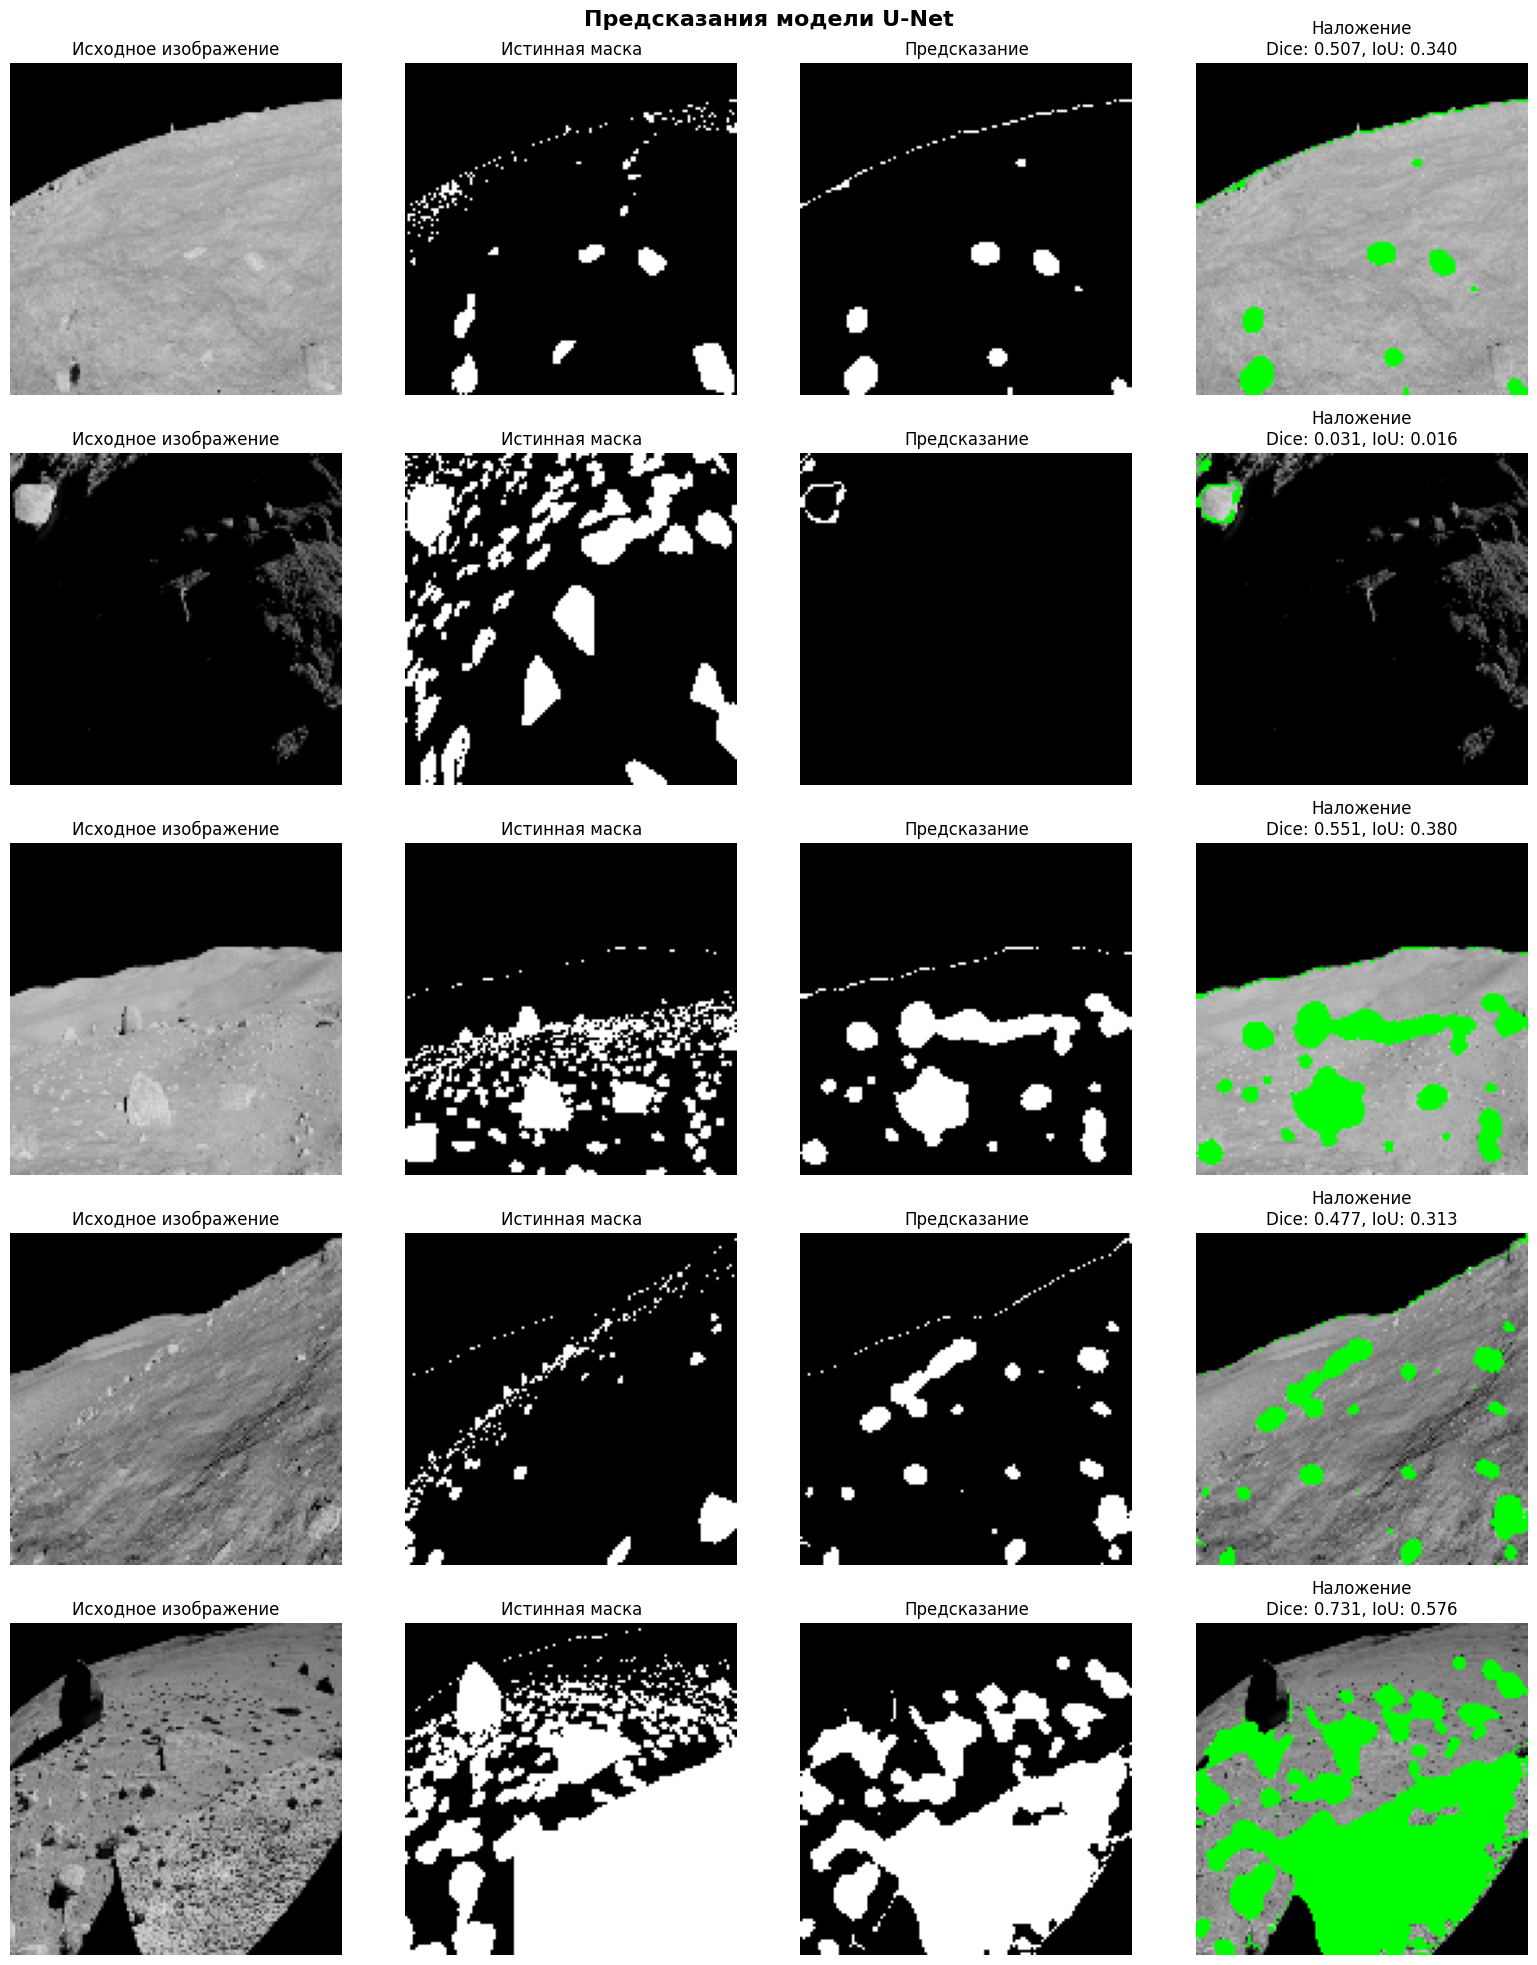

In [46]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)


def plot_segmentation_training_history(history):
    """Визуализация истории обучения сегментации"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o', linewidth=2)
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='s', linewidth=2)
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o', linewidth=2)
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='s', linewidth=2)
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['learning_rate'], label='Learning Rate',
                   marker='o', linewidth=2, color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Результаты обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Вывод итоговых метрик
    print("Итоговые метрики обучения:")
    print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"  Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"  Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"  Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"  Val Accuracy: {history['val_acc'][-1]:.4f}")


def visualize_predictions(model, dataloader, device, num_samples=4):
    """Визуализация предсказаний модели"""
    model.eval()
    model.to(device)

    # Сбор батча изображений
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break

    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    for i in range(min(num_samples, len(images))):
        # Денормализация изображения
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i].numpy()
        mask_pred = predictions[i, 0].numpy()

        # Исходное изображение
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')

        # Истинная маска
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')

        # Предсказание
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')

        # Наложение
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]  # Зеленый цвет для предсказаний

        axes[i, 3].imshow(overlay)

        # Вычисление метрик
        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1].unsqueeze(1))
        iou = iou_score(predictions[i:i+1], masks[i:i+1].unsqueeze(1))

        axes[i, 3].set_title(f'Наложение\nDice: {dice:.3f}, IoU: {iou:.3f}', fontsize=12)
        axes[i, 3].axis('off')

    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Визуализация истории обучения
plot_segmentation_training_history(history_unet)

# Визуализация предсказаний
visualize_predictions(trained_unet, val_loader_seg, device, num_samples=5)

* Фаза 1: Эпохи 1-4 (LR=1e-4)
Train loss немного уменьшается (0.8412→0.8383),
Val метрики абсолютно стабильны,
LR scheduler не срабатывает (val Dice не улучшается)

* Фаза 2: Эпохи 5-8 (LR=5e-5)
Первое уменьшение LR на эпохе 5 (val Dice не улучшался 3 эпохи,
Train loss продолжает медленно уменьшаться,
Val метрики всё так же стабильны

* Фаза 3: Эпохи 9-60 (LR постоянно уменьшается до 0),
LR уменьшается каждые 3-4 эпохи, так как val Dice не улучшается,
К эпохе 33 LR достигает 0,
Все последующие 27 эпох (33-60) обучение идёт с LR=0 — бесполезно

## Часть 3. U-Net с бэкбоном из классификатора

### 3.1 Архитектура ResNet-UNet

In [47]:
class ResNetUNet(nn.Module):
    """U-Net с бэкбоном из предобученного классификатора"""

    def __init__(self, classifier_state_dict, out_channels=1,
                 features=[32, 64, 128, 256], freeze_encoder=True):
        super().__init__()

        # Загрузка предобученного классификатора
        self.classifier = ResNetClassifier(num_classes=len(SELECTED_CLASSES))
        self.classifier.load_state_dict(classifier_state_dict)

        # Заморозка энкодера (если требуется)
        self.freeze_encoder = freeze_encoder
        if freeze_encoder:
            for param in self.classifier.parameters():
                param.requires_grad = False
            print("Энкодер классификатора заморожен")
        else:
            print("Энкодер классификатора разморожен")

        # Декодер
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder (upsampling path)
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, 2, 2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        # Final convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, 1),
            nn.Sigmoid()
        )

        # Подсчет параметров
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print(f"Архитектура ResNet-UNet:")
        print(f"  Всего параметров: {total_params:,}")
        print(f"  Обучаемых параметров: {trainable_params:,}")
        print(f"  Уровней энкодера: {len(features)}")
        print(f"  Конфигурация каналов: {features}")

    def forward(self, x):
        # Получение признаков от энкодера классификатора
        features = []

        # Энкодер классификатора
        x = self.classifier.block1(x)
        features.append(x)  # Level 1: [B, 32, 128, 128]

        x = self.classifier.block2(x)
        features.append(x)  # Level 2: [B, 64, 64, 64]

        x = self.classifier.block3(x)
        features.append(x)  # Level 3: [B, 128, 32, 32]

        x = self.classifier.block4(x)
        features.append(x)  # Level 4: [B, 256, 16, 16]

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections
        features = features[::-1]

        # Decoder
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)  # Upsample

            skip_connection = features[idx // 2]

            # Проверка размеров
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            # Конкатенация с skip connection
            x = torch.cat([skip_connection, x], dim=1)

            # Двойная свертка
            x = self.decoder_blocks[idx + 1](x)

        # Final output
        output = self.final_conv(x)

        return output

## 3.2 Обучение ResNet-UNet с замороженным энкодером (Вариант A)

Энкодер классификатора заморожен
Архитектура ResNet-UNet:
  Всего параметров: 7,809,418
  Обучаемых параметров: 6,589,825
  Уровней энкодера: 4
  Конфигурация каналов: [32, 64, 128, 256]
Начало обучения сегментации на 60 эпох...
Размер батча: 4
Общее количество батчей в эпоху: 20

Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s, loss=0.8972, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 1:
  Train - Loss: 0.8960, Dice: 0.1668, IoU: 0.0932
  Val - Loss: 0.8496, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100
Сохранена лучшая модель с Dice: 0.2381

Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s, loss=0.9039, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 2:
  Train - Loss: 0.8834, Dice: 0.1672, IoU: 0.0935
  Val - Loss: 0.8452, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s, loss=0.8798, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 3:
  Train - Loss: 0.8740, Dice: 0.1675, IoU: 0.0938
  Val - Loss: 0.8278, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.98it/s, loss=0.8765, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 4:
  Train - Loss: 0.8686, Dice: 0.1658, IoU: 0.0935
  Val - Loss: 0.8214, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000100

Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s, loss=0.8672, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 5:
  Train - Loss: 0.8641, Dice: 0.1649, IoU: 0.0931
  Val - Loss: 0.8170, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s, loss=0.8671, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 6:
  Train - Loss: 0.8584, Dice: 0.1661, IoU: 0.0923
  Val - Loss: 0.8154, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s, loss=0.8593, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 7:
  Train - Loss: 0.8540, Dice: 0.1686, IoU: 0.0938
  Val - Loss: 0.8115, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.32it/s, loss=0.8597, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 8:
  Train - Loss: 0.8521, Dice: 0.1685, IoU: 0.0941
  Val - Loss: 0.8094, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000050

Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s, loss=0.8599, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 9:
  Train - Loss: 0.8527, Dice: 0.1643, IoU: 0.0920
  Val - Loss: 0.8094, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s, loss=0.8561, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 10:
  Train - Loss: 0.8495, Dice: 0.1666, IoU: 0.0921
  Val - Loss: 0.8078, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.27it/s, loss=0.8534, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 11:
  Train - Loss: 0.8508, Dice: 0.1645, IoU: 0.0910
  Val - Loss: 0.8061, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s, loss=0.8555, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 12:
  Train - Loss: 0.8498, Dice: 0.1653, IoU: 0.0925
  Val - Loss: 0.8071, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000025

Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s, loss=0.8542, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 13:
  Train - Loss: 0.8501, Dice: 0.1643, IoU: 0.0917
  Val - Loss: 0.8060, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.31it/s, loss=0.8526, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 14:
  Train - Loss: 0.8482, Dice: 0.1668, IoU: 0.0932
  Val - Loss: 0.8054, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s, loss=0.8519, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 15:
  Train - Loss: 0.8452, Dice: 0.1695, IoU: 0.0940
  Val - Loss: 0.8044, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s, loss=0.8535, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 16:
  Train - Loss: 0.8495, Dice: 0.1640, IoU: 0.0923
  Val - Loss: 0.8056, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000013

Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s, loss=0.8514, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 17:
  Train - Loss: 0.8466, Dice: 0.1682, IoU: 0.0939
  Val - Loss: 0.8041, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.97it/s, loss=0.8519, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 18:
  Train - Loss: 0.8481, Dice: 0.1672, IoU: 0.0939
  Val - Loss: 0.8041, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s, loss=0.8500, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 19:
  Train - Loss: 0.8459, Dice: 0.1677, IoU: 0.0934
  Val - Loss: 0.8036, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.54it/s, loss=0.8510, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 20:
  Train - Loss: 0.8442, Dice: 0.1694, IoU: 0.0932
  Val - Loss: 0.8037, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000006

Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s, loss=0.8525, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 21:
  Train - Loss: 0.8457, Dice: 0.1676, IoU: 0.0936
  Val - Loss: 0.8046, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.56it/s, loss=0.8511, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 22:
  Train - Loss: 0.8481, Dice: 0.1649, IoU: 0.0925
  Val - Loss: 0.8038, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s, loss=0.8504, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 23:
  Train - Loss: 0.8447, Dice: 0.1685, IoU: 0.0941
  Val - Loss: 0.8031, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 24:
  Train - Loss: 0.8464, Dice: 0.1661, IoU: 0.0927
  Val - Loss: 0.8037, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000003

Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 25:
  Train - Loss: 0.8465, Dice: 0.1659, IoU: 0.0930
  Val - Loss: 0.8037, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s, loss=0.8514, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 26:
  Train - Loss: 0.8480, Dice: 0.1644, IoU: 0.0922
  Val - Loss: 0.8038, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s, loss=0.8510, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 27:
  Train - Loss: 0.8469, Dice: 0.1662, IoU: 0.0929
  Val - Loss: 0.8036, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 28:
  Train - Loss: 0.8457, Dice: 0.1661, IoU: 0.0921
  Val - Loss: 0.8036, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000002

Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.21it/s, loss=0.8506, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 29:
  Train - Loss: 0.8468, Dice: 0.1668, IoU: 0.0941
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s, loss=0.8502, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 30:
  Train - Loss: 0.8455, Dice: 0.1672, IoU: 0.0931
  Val - Loss: 0.8030, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s, loss=0.8513, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 31:
  Train - Loss: 0.8476, Dice: 0.1654, IoU: 0.0929
  Val - Loss: 0.8039, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 32:
  Train - Loss: 0.8466, Dice: 0.1668, IoU: 0.0931
  Val - Loss: 0.8034, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000001

Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s, loss=0.8512, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 33:
  Train - Loss: 0.8473, Dice: 0.1645, IoU: 0.0921
  Val - Loss: 0.8036, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s, loss=0.8503, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 34:
  Train - Loss: 0.8451, Dice: 0.1672, IoU: 0.0930
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s, loss=0.8522, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 35:
  Train - Loss: 0.8463, Dice: 0.1669, IoU: 0.0933
  Val - Loss: 0.8044, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s, loss=0.8507, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 36:
  Train - Loss: 0.8468, Dice: 0.1660, IoU: 0.0921
  Val - Loss: 0.8039, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s, loss=0.8502, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 37:
  Train - Loss: 0.8468, Dice: 0.1650, IoU: 0.0921
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s, loss=0.8513, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 38:
  Train - Loss: 0.8459, Dice: 0.1673, IoU: 0.0932
  Val - Loss: 0.8040, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s, loss=0.8507, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 39:
  Train - Loss: 0.8462, Dice: 0.1670, IoU: 0.0940
  Val - Loss: 0.8033, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s, loss=0.8504, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 40:
  Train - Loss: 0.8472, Dice: 0.1656, IoU: 0.0930
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 11.63it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 41:
  Train - Loss: 0.8460, Dice: 0.1668, IoU: 0.0935
  Val - Loss: 0.8033, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s, loss=0.8504, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 42:
  Train - Loss: 0.8443, Dice: 0.1688, IoU: 0.0938
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.20it/s, loss=0.8505, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 43:
  Train - Loss: 0.8438, Dice: 0.1692, IoU: 0.0942
  Val - Loss: 0.8031, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s, loss=0.8508, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 44:
  Train - Loss: 0.8427, Dice: 0.1706, IoU: 0.0942
  Val - Loss: 0.8033, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s, loss=0.8492, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 45:
  Train - Loss: 0.8465, Dice: 0.1668, IoU: 0.0932
  Val - Loss: 0.8022, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s, loss=0.8502, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 46:
  Train - Loss: 0.8448, Dice: 0.1678, IoU: 0.0933
  Val - Loss: 0.8031, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.60it/s, loss=0.8515, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 47:
  Train - Loss: 0.8437, Dice: 0.1693, IoU: 0.0939
  Val - Loss: 0.8038, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s, loss=0.8512, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 48:
  Train - Loss: 0.8444, Dice: 0.1694, IoU: 0.0941
  Val - Loss: 0.8038, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.63it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 49:
  Train - Loss: 0.8461, Dice: 0.1657, IoU: 0.0918
  Val - Loss: 0.8033, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.97it/s, loss=0.8507, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 50:
  Train - Loss: 0.8440, Dice: 0.1701, IoU: 0.0950
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s, loss=0.8524, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 51:
  Train - Loss: 0.8463, Dice: 0.1678, IoU: 0.0939
  Val - Loss: 0.8040, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s, loss=0.8532, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 52:
  Train - Loss: 0.8471, Dice: 0.1661, IoU: 0.0927
  Val - Loss: 0.8048, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s, loss=0.8507, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 53:
  Train - Loss: 0.8446, Dice: 0.1696, IoU: 0.0948
  Val - Loss: 0.8035, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s, loss=0.8510, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 54:
  Train - Loss: 0.8462, Dice: 0.1661, IoU: 0.0923
  Val - Loss: 0.8033, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s, loss=0.8503, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 55:
  Train - Loss: 0.8465, Dice: 0.1655, IoU: 0.0924
  Val - Loss: 0.8032, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s, loss=0.8509, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 56:
  Train - Loss: 0.8470, Dice: 0.1643, IoU: 0.0914
  Val - Loss: 0.8036, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s, loss=0.8507, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 57:
  Train - Loss: 0.8461, Dice: 0.1660, IoU: 0.0922
  Val - Loss: 0.8034, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s, loss=0.8500, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 58:
  Train - Loss: 0.8455, Dice: 0.1672, IoU: 0.0929
  Val - Loss: 0.8030, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s, loss=0.8503, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 59:
  Train - Loss: 0.8470, Dice: 0.1659, IoU: 0.0934
  Val - Loss: 0.8034, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s, loss=0.8504, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 60:
  Train - Loss: 0.8459, Dice: 0.1664, IoU: 0.0921
  Val - Loss: 0.8030, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  Learning Rate: 0.000000

Обучение завершено
Лучший Dice на валидации: 0.2381


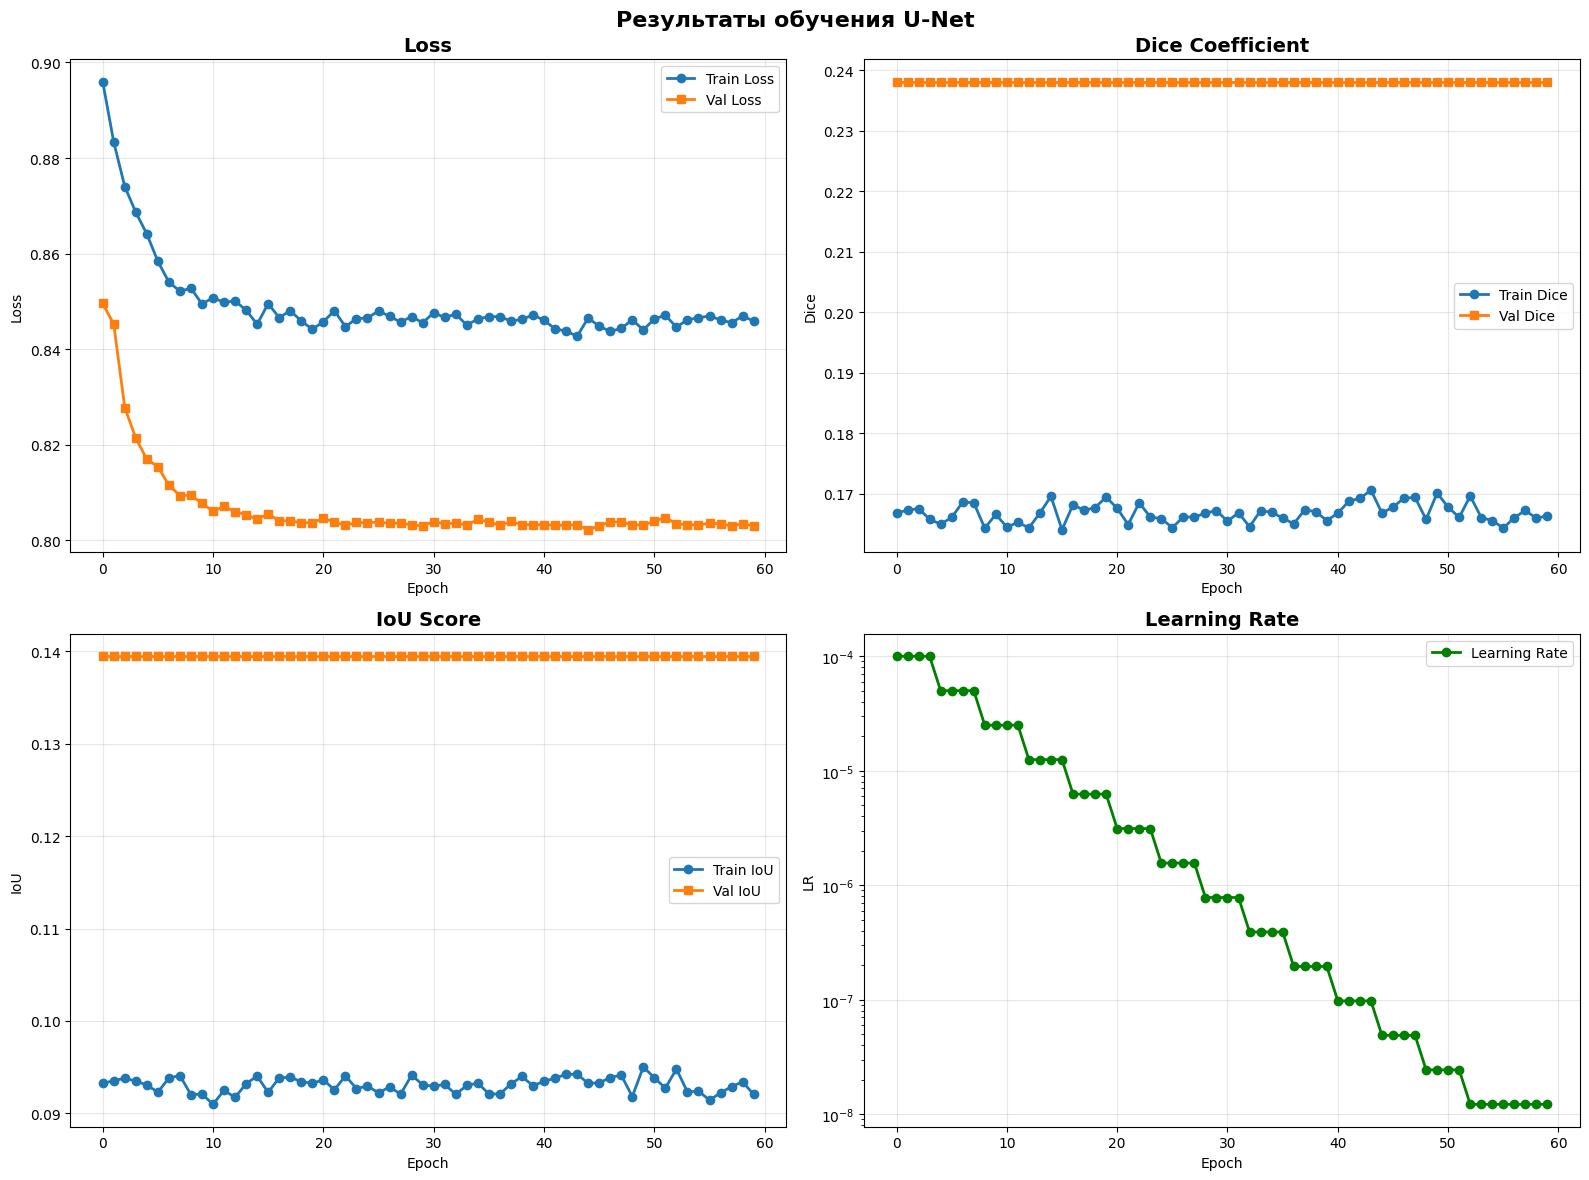

Итоговые метрики обучения:
  Train Loss: 0.8459
  Val Loss: 0.8030
  Train Dice: 0.1664
  Val Dice: 0.2381
  Train IoU: 0.0921
  Val IoU: 0.1395
  Val Accuracy: 0.1395


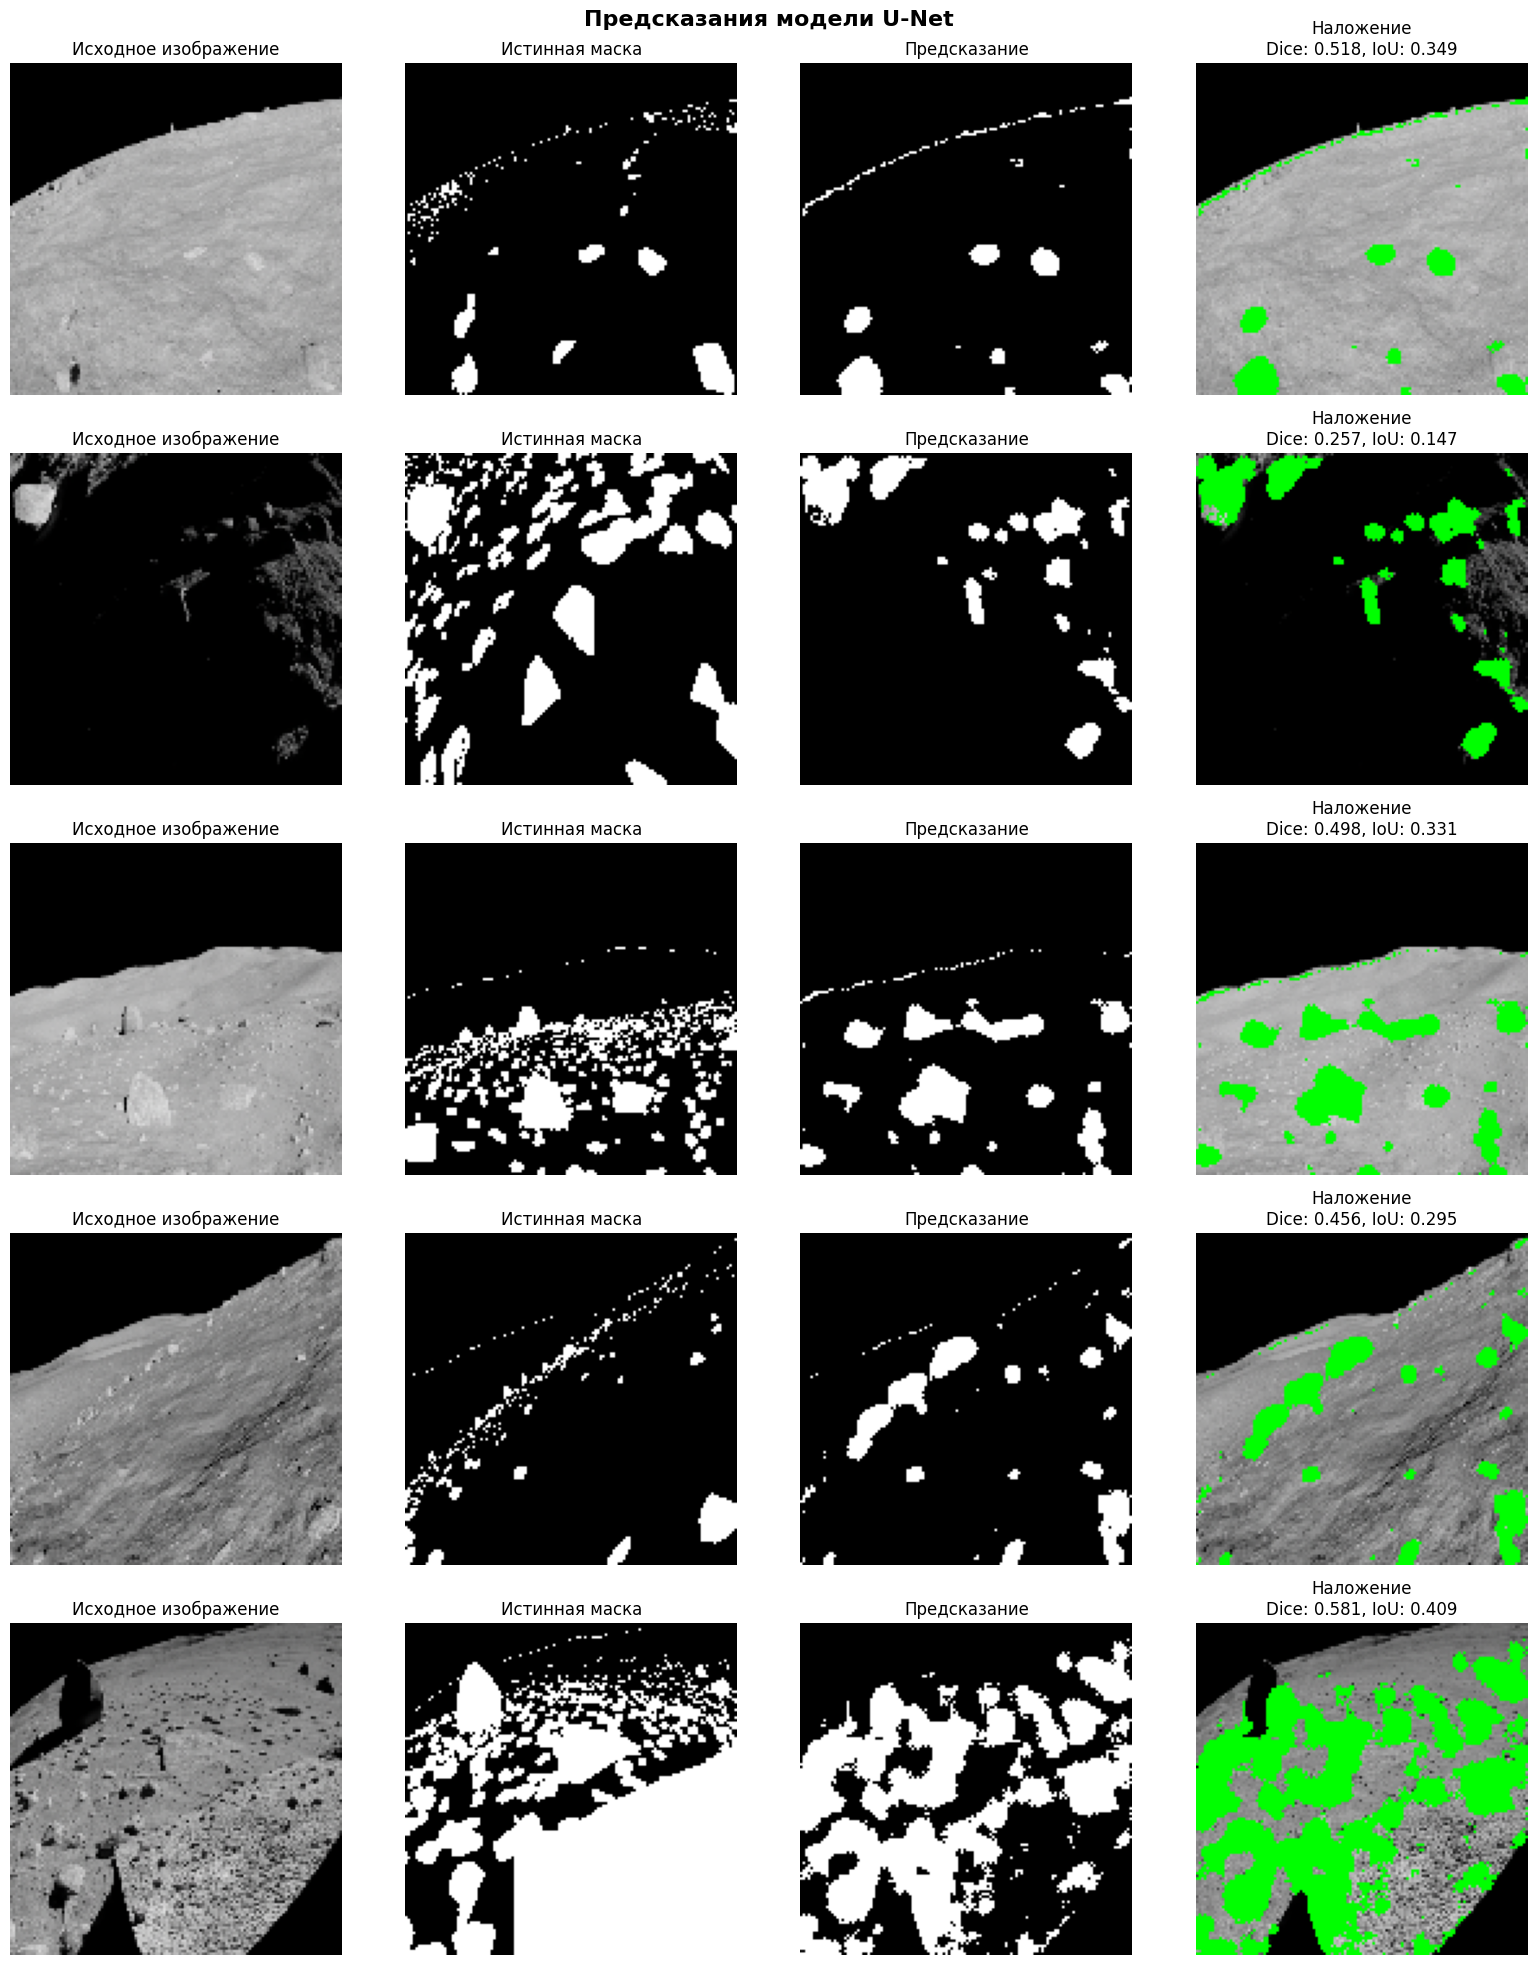

In [48]:
# Загрузка весов предобученного классификатора
checkpoint = torch.load("best_classifier.pth", map_location=device)
classifier_state_dict = checkpoint['model_state_dict']

# Создание модели с замороженным энкодером
resnet_unet_a = ResNetUNet(
    classifier_state_dict=classifier_state_dict,
    out_channels=1,
    features=[32, 64, 128, 256],
    freeze_encoder=True
)

# Обучение модели
history_resnet_unet_a, trained_resnet_unet_a = train_segmentation_model(
    model=resnet_unet_a,
    train_loader=train_loader_seg,
    val_loader=val_loader_seg,
    num_epochs=60,
    learning_rate=1e-4,
    save_path="best_resnet_unet_a.pth"
)

# Визуализация результатов
plot_segmentation_training_history(history_resnet_unet_a)
visualize_predictions(trained_resnet_unet_a, val_loader_seg, device, num_samples=5)

* Фаза активного обучения (эпохи 1-32):
LR уменьшается 8 раз, Train loss уменьшается с 0.8960 до 0.8466, val метрики стабильны

* Фаза без обучения (эпохи 33-60):
LR = 0 с эпохи 33, 28 эпох обучение не происходит (градиенты не обновляются)

ResNet-UNet с замороженным энкодером не лучше базовой U-Net

### 3.3 Обучение ResNet-UNet с размороженным энкодером (Вариант B)

Энкодер классификатора разморожен
Архитектура ResNet-UNet:
  Всего параметров: 7,809,418
  Обучаемых параметров: 7,809,418
  Уровней энкодера: 4
  Конфигурация каналов: [32, 64, 128, 256]
Начало обучения ResNet-UNet с размороженным энкодером на 60 эпох...
LR энкодера: 1e-5, LR декодера: 1e-4

Эпоха 1/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s, loss=0.8704, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 1:
  Train - Loss: 0.8574, Dice: 0.1677, IoU: 0.0938
  Val - Loss: 0.8241, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000010, LR декодера: 0.000100
  ✓ Сохранена лучшая модель с Dice: 0.2381

Эпоха 2/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s, loss=0.8653, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 2:
  Train - Loss: 0.8453, Dice: 0.1688, IoU: 0.0943
  Val - Loss: 0.8108, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000010, LR декодера: 0.000100

Эпоха 3/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.10it/s, loss=0.8588, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 3:
  Train - Loss: 0.8358, Dice: 0.1682, IoU: 0.0933
  Val - Loss: 0.8035, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000010, LR декодера: 0.000100

Эпоха 4/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s, loss=0.8395, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 4:
  Train - Loss: 0.8305, Dice: 0.1663, IoU: 0.0923
  Val - Loss: 0.7883, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000010, LR декодера: 0.000100

Эпоха 5/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=0.8415, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 5:
  Train - Loss: 0.8256, Dice: 0.1655, IoU: 0.0924
  Val - Loss: 0.7878, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000005, LR декодера: 0.000050

Эпоха 6/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s, loss=0.8237, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 6:
  Train - Loss: 0.8207, Dice: 0.1680, IoU: 0.0932
  Val - Loss: 0.7794, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000005, LR декодера: 0.000050

Эпоха 7/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.44it/s, loss=0.8210, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 7:
  Train - Loss: 0.8205, Dice: 0.1667, IoU: 0.0927
  Val - Loss: 0.7782, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000005, LR декодера: 0.000050

Эпоха 8/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s, loss=0.8223, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 8:
  Train - Loss: 0.8222, Dice: 0.1636, IoU: 0.0934
  Val - Loss: 0.7773, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000005, LR декодера: 0.000050

Эпоха 9/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s, loss=0.8209, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 9:
  Train - Loss: 0.8181, Dice: 0.1674, IoU: 0.0939
  Val - Loss: 0.7761, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000003, LR декодера: 0.000025

Эпоха 10/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.86it/s, loss=0.8201, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 10:
  Train - Loss: 0.8207, Dice: 0.1638, IoU: 0.0931
  Val - Loss: 0.7766, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000003, LR декодера: 0.000025

Эпоха 11/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s, loss=0.8187, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 11:
  Train - Loss: 0.8156, Dice: 0.1685, IoU: 0.0941
  Val - Loss: 0.7752, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000003, LR декодера: 0.000025

Эпоха 12/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s, loss=0.8183, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 12:
  Train - Loss: 0.8169, Dice: 0.1648, IoU: 0.0916
  Val - Loss: 0.7752, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000003, LR декодера: 0.000025

Эпоха 13/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.61it/s, loss=0.8143, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 13:
  Train - Loss: 0.8140, Dice: 0.1683, IoU: 0.0934
  Val - Loss: 0.7725, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000013

Эпоха 14/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.00it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 14:
  Train - Loss: 0.8134, Dice: 0.1688, IoU: 0.0936
  Val - Loss: 0.7721, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000013

Эпоха 15/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s, loss=0.8176, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 15:
  Train - Loss: 0.8157, Dice: 0.1653, IoU: 0.0915
  Val - Loss: 0.7743, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000013

Эпоха 16/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 16:
  Train - Loss: 0.8156, Dice: 0.1646, IoU: 0.0914
  Val - Loss: 0.7719, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000013

Эпоха 17/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s, loss=0.8193, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 17:
  Train - Loss: 0.8147, Dice: 0.1655, IoU: 0.0917
  Val - Loss: 0.7747, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000006

Эпоха 18/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s, loss=0.8172, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 18:
  Train - Loss: 0.8140, Dice: 0.1668, IoU: 0.0925
  Val - Loss: 0.7731, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000006

Эпоха 19/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s, loss=0.8155, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 19:
  Train - Loss: 0.8162, Dice: 0.1663, IoU: 0.0938
  Val - Loss: 0.7724, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000006

Эпоха 20/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s, loss=0.8140, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 20:
  Train - Loss: 0.8129, Dice: 0.1661, IoU: 0.0921
  Val - Loss: 0.7714, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000001, LR декодера: 0.000006

Эпоха 21/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 21:
  Train - Loss: 0.8134, Dice: 0.1658, IoU: 0.0926
  Val - Loss: 0.7719, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000003

Эпоха 22/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.54it/s, loss=0.8149, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 22:
  Train - Loss: 0.8127, Dice: 0.1668, IoU: 0.0933
  Val - Loss: 0.7721, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000003

Эпоха 23/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.68it/s, loss=0.8162, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 23:
  Train - Loss: 0.8141, Dice: 0.1678, IoU: 0.0940
  Val - Loss: 0.7731, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000003

Эпоха 24/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s, loss=0.8163, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 24:
  Train - Loss: 0.8137, Dice: 0.1657, IoU: 0.0918
  Val - Loss: 0.7729, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000003

Эпоха 25/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.30it/s, loss=0.8132, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 25:
  Train - Loss: 0.8114, Dice: 0.1678, IoU: 0.0925
  Val - Loss: 0.7711, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000002

Эпоха 26/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s, loss=0.8124, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 26:
  Train - Loss: 0.8134, Dice: 0.1680, IoU: 0.0939
  Val - Loss: 0.7703, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000002

Эпоха 27/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.14it/s, loss=0.8134, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 27:
  Train - Loss: 0.8113, Dice: 0.1696, IoU: 0.0946
  Val - Loss: 0.7709, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000002

Эпоха 28/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s, loss=0.8143, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 28:
  Train - Loss: 0.8157, Dice: 0.1633, IoU: 0.0917
  Val - Loss: 0.7712, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000002

Эпоха 29/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s, loss=0.8153, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 29:
  Train - Loss: 0.8157, Dice: 0.1648, IoU: 0.0929
  Val - Loss: 0.7719, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000001

Эпоха 30/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.67it/s, loss=0.8148, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 30:
  Train - Loss: 0.8132, Dice: 0.1665, IoU: 0.0922
  Val - Loss: 0.7718, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000001

Эпоха 31/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.30it/s, loss=0.8143, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 31:
  Train - Loss: 0.8119, Dice: 0.1688, IoU: 0.0936
  Val - Loss: 0.7717, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000001

Эпоха 32/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s, loss=0.8140, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 32:
  Train - Loss: 0.8131, Dice: 0.1682, IoU: 0.0942
  Val - Loss: 0.7713, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000001

Эпоха 33/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s, loss=0.8136, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 33:
  Train - Loss: 0.8116, Dice: 0.1680, IoU: 0.0932
  Val - Loss: 0.7707, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 34/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.32it/s, loss=0.8131, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 34:
  Train - Loss: 0.8121, Dice: 0.1679, IoU: 0.0929
  Val - Loss: 0.7709, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 35/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.45it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 35:
  Train - Loss: 0.8151, Dice: 0.1635, IoU: 0.0915
  Val - Loss: 0.7717, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 36/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s, loss=0.8131, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 36:
  Train - Loss: 0.8138, Dice: 0.1655, IoU: 0.0924
  Val - Loss: 0.7708, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 37/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s, loss=0.8158, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 37:
  Train - Loss: 0.8135, Dice: 0.1661, IoU: 0.0924
  Val - Loss: 0.7728, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 38/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.07it/s, loss=0.8138, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 38:
  Train - Loss: 0.8115, Dice: 0.1674, IoU: 0.0925
  Val - Loss: 0.7714, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 39/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.15it/s, loss=0.8145, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 39:
  Train - Loss: 0.8136, Dice: 0.1670, IoU: 0.0935
  Val - Loss: 0.7720, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 40/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s, loss=0.8137, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 40:
  Train - Loss: 0.8128, Dice: 0.1682, IoU: 0.0937
  Val - Loss: 0.7711, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 41/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s, loss=0.8147, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 41:
  Train - Loss: 0.8122, Dice: 0.1685, IoU: 0.0938
  Val - Loss: 0.7719, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 42/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.80it/s, loss=0.8157, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 42:
  Train - Loss: 0.8150, Dice: 0.1636, IoU: 0.0908
  Val - Loss: 0.7730, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 43/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.78it/s, loss=0.8143, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 43:
  Train - Loss: 0.8109, Dice: 0.1690, IoU: 0.0938
  Val - Loss: 0.7720, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 44/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s, loss=0.8151, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 44:
  Train - Loss: 0.8131, Dice: 0.1664, IoU: 0.0933
  Val - Loss: 0.7720, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 45/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s, loss=0.8146, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 45:
  Train - Loss: 0.8139, Dice: 0.1669, IoU: 0.0935
  Val - Loss: 0.7716, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 46/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s, loss=0.8143, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 46:
  Train - Loss: 0.8127, Dice: 0.1669, IoU: 0.0931
  Val - Loss: 0.7720, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 47/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s, loss=0.8141, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 47:
  Train - Loss: 0.8121, Dice: 0.1687, IoU: 0.0936
  Val - Loss: 0.7712, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 48/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.68it/s, loss=0.8137, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 48:
  Train - Loss: 0.8148, Dice: 0.1639, IoU: 0.0907
  Val - Loss: 0.7710, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 49/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s, loss=0.8134, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 49:
  Train - Loss: 0.8121, Dice: 0.1686, IoU: 0.0941
  Val - Loss: 0.7713, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 50/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 50:
  Train - Loss: 0.8134, Dice: 0.1673, IoU: 0.0932
  Val - Loss: 0.7716, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 51/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.72it/s, loss=0.8149, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 51:
  Train - Loss: 0.8147, Dice: 0.1642, IoU: 0.0912
  Val - Loss: 0.7718, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 52/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s, loss=0.8142, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 52:
  Train - Loss: 0.8144, Dice: 0.1642, IoU: 0.0911
  Val - Loss: 0.7713, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 53/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s, loss=0.8153, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 53:
  Train - Loss: 0.8143, Dice: 0.1642, IoU: 0.0913
  Val - Loss: 0.7718, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 54/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s, loss=0.8152, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 54:
  Train - Loss: 0.8144, Dice: 0.1646, IoU: 0.0920
  Val - Loss: 0.7722, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 55/60


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s, loss=0.8132, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 55:
  Train - Loss: 0.8115, Dice: 0.1689, IoU: 0.0943
  Val - Loss: 0.7708, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 56/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s, loss=0.8130, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 56:
  Train - Loss: 0.8106, Dice: 0.1685, IoU: 0.0931
  Val - Loss: 0.7712, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 57/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.96it/s, loss=0.8137, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 57:
  Train - Loss: 0.8115, Dice: 0.1683, IoU: 0.0928
  Val - Loss: 0.7712, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 58/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.10it/s, loss=0.8133, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 58:
  Train - Loss: 0.8135, Dice: 0.1669, IoU: 0.0940
  Val - Loss: 0.7711, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 59/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.38it/s, loss=0.8150, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 59:
  Train - Loss: 0.8109, Dice: 0.1690, IoU: 0.0939
  Val - Loss: 0.7716, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Эпоха 60/60


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.21it/s, loss=0.8147, dice=0.1625, iou=0.0884, acc=0.0884]



Результаты эпохи 60:
  Train - Loss: 0.8132, Dice: 0.1665, IoU: 0.0935
  Val - Loss: 0.7720, Dice: 0.2381, IoU: 0.1395, Acc: 0.1395
  LR энкодера: 0.000000, LR декодера: 0.000000

Обучение завершено!
Лучший Dice на валидации: 0.2381


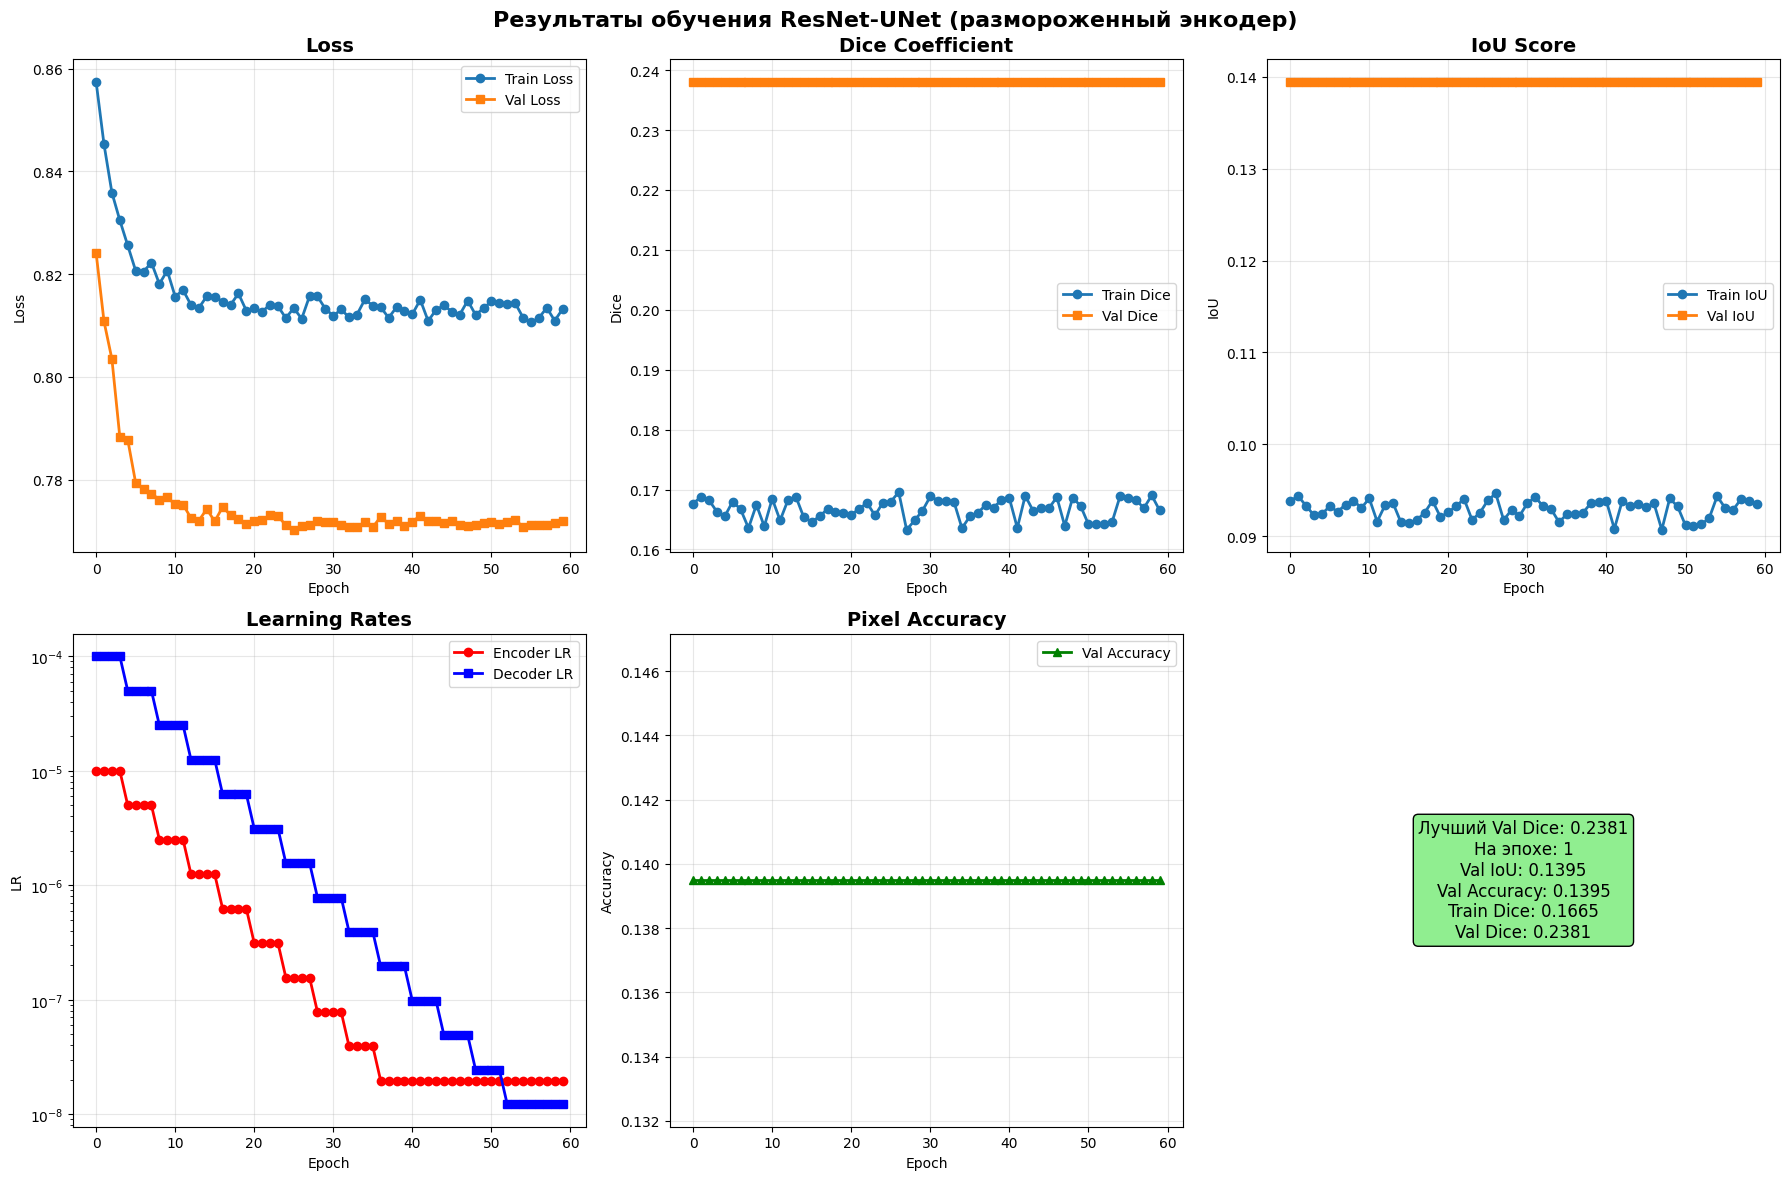

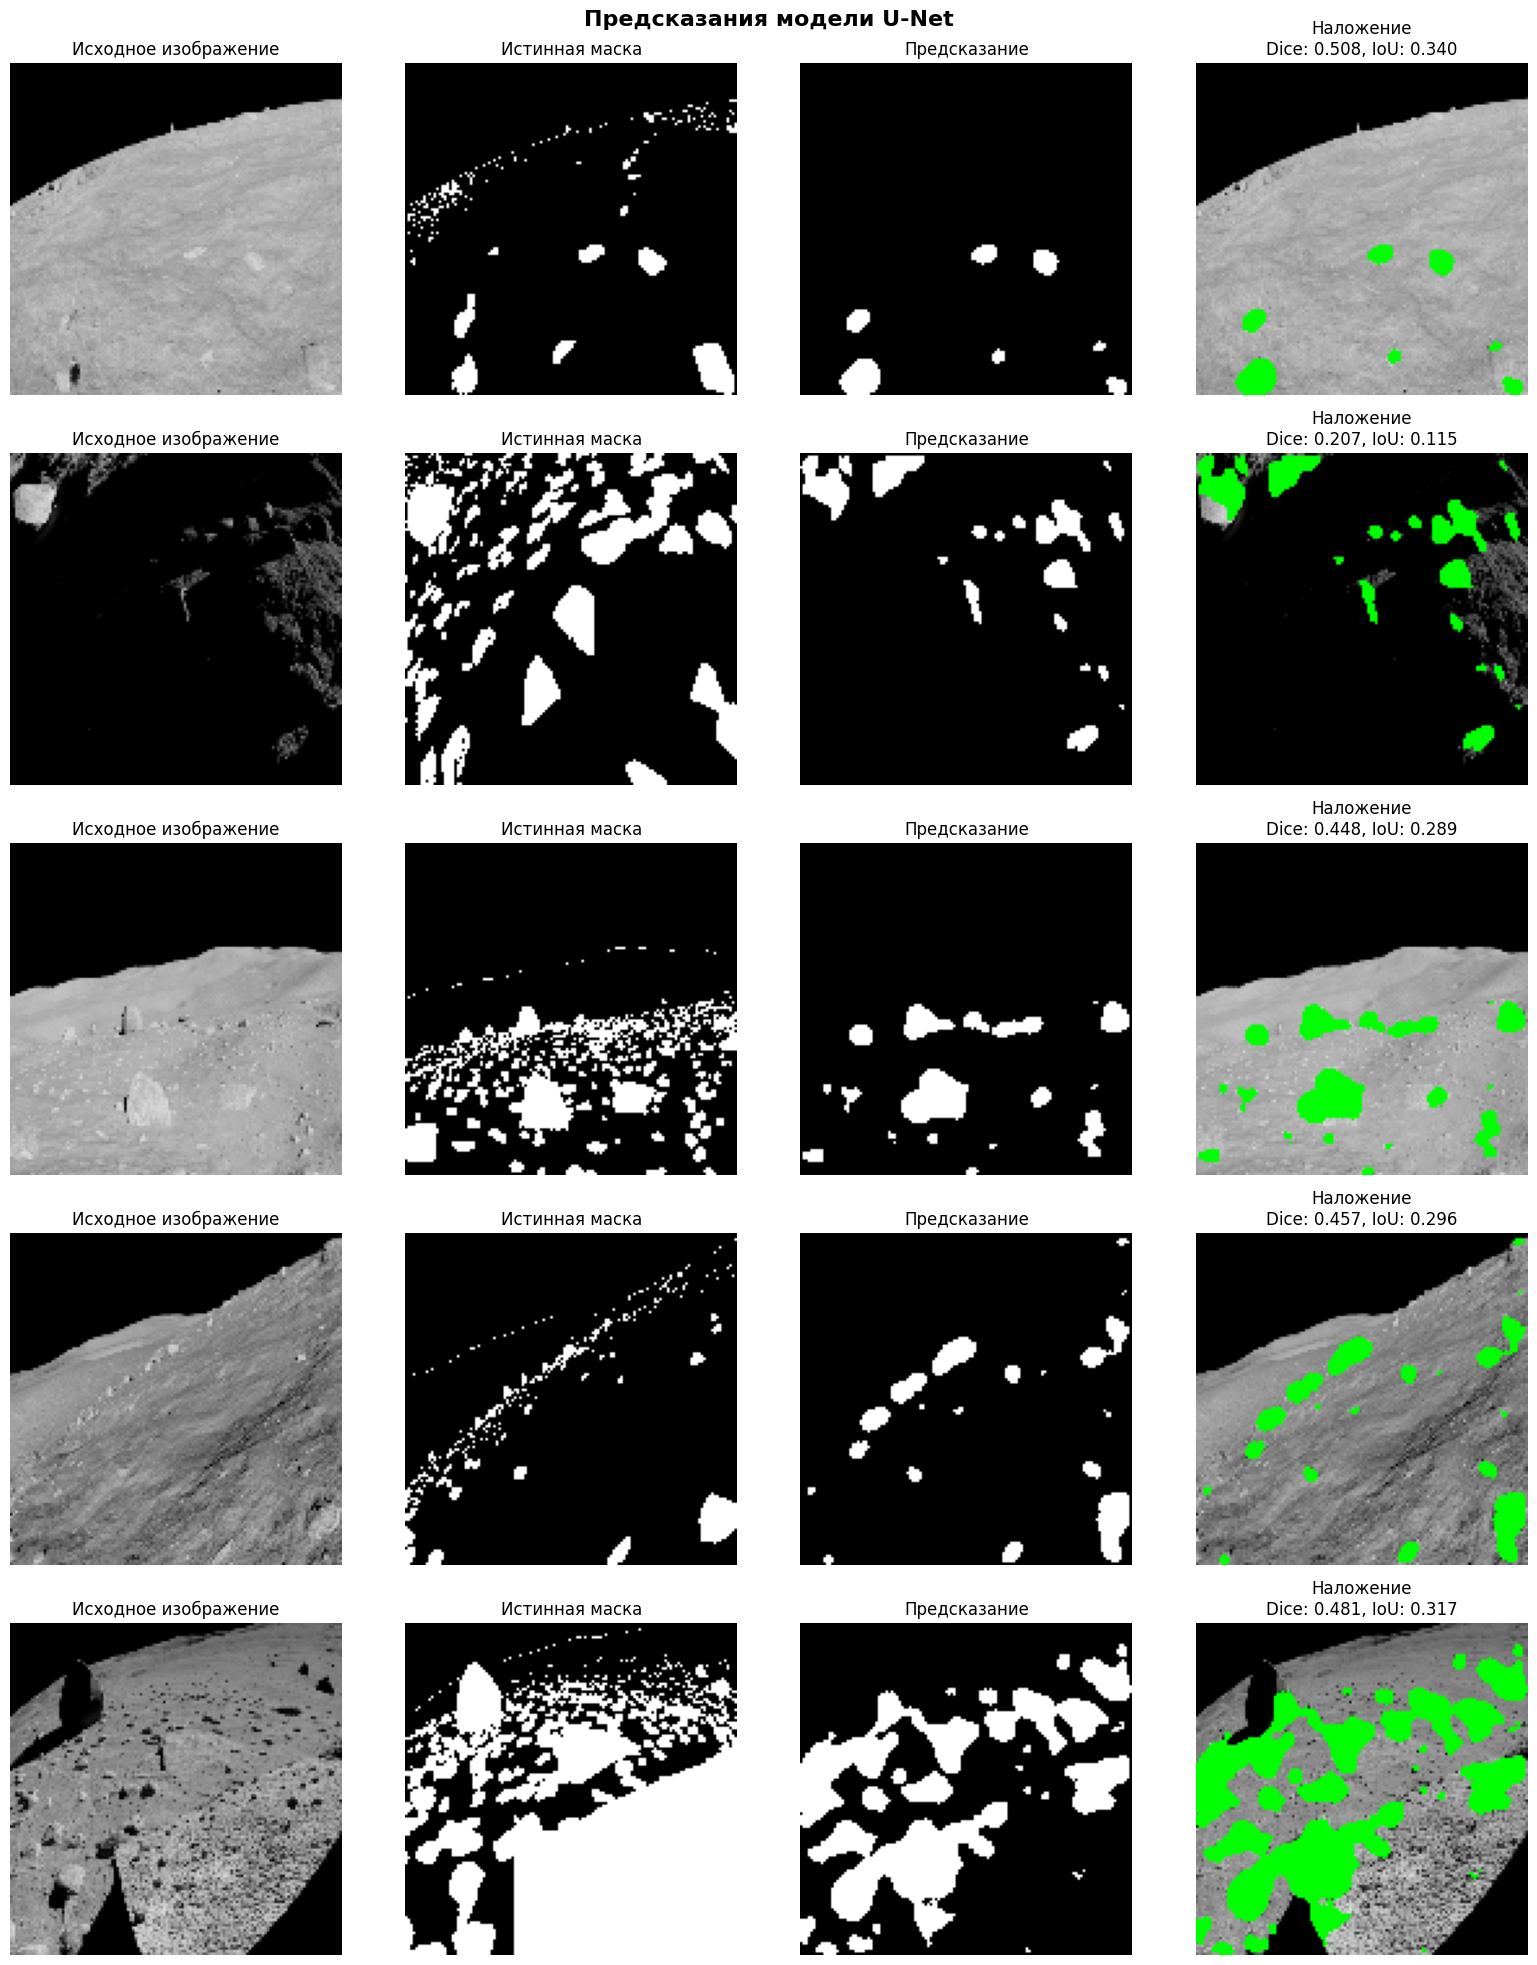

In [49]:
def train_resnet_unet_with_unfrozen_encoder(model, train_loader, val_loader,
                                          num_epochs=60, save_path="best_resnet_unet_b.pth"):
    """Обучение ResNet-UNet с размороженным энкодером"""

    model = model.to(device)

    # Разделение параметров на энкодер и декодер
    encoder_params = []
    decoder_params = []

    for name, param in model.named_parameters():
        if 'classifier' in name:  # Параметры энкодера
            encoder_params.append(param)
        else:  # Параметры декодера
            decoder_params.append(param)

    # Оптимизатор с разными learning rates
    optimizer = torch.optim.Adam([
        {'params': encoder_params, 'lr': 1e-5},  # Меньший LR для энкодера
        {'params': decoder_params, 'lr': 1e-4}   # Обычный LR для декодера
    ], weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

    # История обучения
    history = {
        'train_loss': [], 'train_dice': [], 'train_iou': [],
        'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_acc': [],
        'learning_rate_encoder': [], 'learning_rate_decoder': []
    }

    best_val_dice = 0.0

    print(f"Начало обучения ResNet-UNet с размороженным энкодером на {num_epochs} эпох...")
    print(f"LR энкодера: 1e-5, LR декодера: 1e-4")

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        # Обучение
        train_loss, train_dice, train_iou = train_segmentation_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_dice, val_iou, val_acc = validate_segmentation_epoch(
            model, val_loader, criterion, device
        )

        # Обновление learning rate
        scheduler.step(val_dice)
        current_lr_encoder = optimizer.param_groups[0]['lr']
        current_lr_decoder = optimizer.param_groups[1]['lr']

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['learning_rate_encoder'].append(current_lr_encoder)
        history['learning_rate_decoder'].append(current_lr_decoder)

        # Вывод результатов
        print(f"\nРезультаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR энкодера: {current_lr_encoder:.6f}, LR декодера: {current_lr_decoder:.6f}")

        # Сохранение лучшей модели
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
                'val_acc': val_acc,
            }, save_path)
            print(f"  ✓ Сохранена лучшая модель с Dice: {val_dice:.4f}")

    print(f"\n{'='*50}")
    print(f"Обучение завершено!")
    print(f"Лучший Dice на валидации: {best_val_dice:.4f}")
    print(f"{'='*50}")

    return history, model


# Создание модели с размороженным энкодером
resnet_unet_b = ResNetUNet(
    classifier_state_dict=classifier_state_dict,
    out_channels=1,
    features=[32, 64, 128, 256],
    freeze_encoder=False
)

# Обучение модели
history_resnet_unet_b, trained_resnet_unet_b = train_resnet_unet_with_unfrozen_encoder(
    model=resnet_unet_b,
    train_loader=train_loader_seg,
    val_loader=val_loader_seg,
    num_epochs=60,
    save_path="best_resnet_unet_b.pth"
)

# Визуализация результатов
def plot_resnet_unet_training_history(history):
    """Визуализация истории обучения ResNet-UNet"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o', linewidth=2)
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='s', linewidth=2)
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[0, 2].plot(history['train_iou'], label='Train IoU', marker='o', linewidth=2)
    axes[0, 2].plot(history['val_iou'], label='Val IoU', marker='s', linewidth=2)
    axes[0, 2].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('IoU')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Learning Rates
    axes[1, 0].plot(history['learning_rate_encoder'], label='Encoder LR',
                   marker='o', linewidth=2, color='red')
    axes[1, 0].plot(history['learning_rate_decoder'], label='Decoder LR',
                   marker='s', linewidth=2, color='blue')
    axes[1, 0].set_title('Learning Rates', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Pixel Accuracy
    axes[1, 1].plot(history['val_acc'], label='Val Accuracy',
                   marker='^', linewidth=2, color='green')
    axes[1, 1].set_title('Pixel Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Итоговые метрики
    axes[1, 2].axis('off')
    best_epoch = history['val_dice'].index(max(history['val_dice']))
    axes[1, 2].text(0.5, 0.5,
                   f"Лучший Val Dice: {max(history['val_dice']):.4f}\n"
                   f"На эпохе: {best_epoch + 1}\n"
                   f"Val IoU: {history['val_iou'][best_epoch]:.4f}\n"
                   f"Val Accuracy: {history['val_acc'][best_epoch]:.4f}\n"
                   f"Train Dice: {history['train_dice'][-1]:.4f}\n"
                   f"Val Dice: {history['val_dice'][-1]:.4f}",
                   ha='center', va='center', fontsize=12,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.suptitle('Результаты обучения ResNet-UNet (размороженный энкодер)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_resnet_unet_training_history(history_resnet_unet_b)
visualize_predictions(trained_resnet_unet_b, val_loader_seg, device, num_samples=5)

* Фаза 1: Активное обучение (эпохи 1-32)

Эпохи 1-4: LR энкодера=1e-5, декодера=1e-4

Эпоха 5: LR уменьшается вдвое (val Dice не улучшался 3 эпохи)

Эпохи 5-8: LR энкодера=5e-6, декодера=5e-5

Эпохи 9-12: LR уменьшается до 2.5e-6 / 2.5e-5

Эпохи 13-16: LR уменьшается до 1.25e-6 / 1.25e-5

Эпохи 17-20: LR уменьшается до 6.25e-7 / 6.25e-6

Эпохи 21-24: LR уменьшается до 3.125e-7 / 3.125e-6

Эпохи 25-28: LR уменьшается до 1.56e-7 / 1.56e-6

Эпохи 29-32: LR уменьшается до 7.8e-8 / 7.8e-7

* Фаза 2: Обучение остановлено (эпохи 33-60)

С эпохи 33: LR = 0 для обоих компонентов

28 эпох обучение не происходит (градиенты не обновляются)

### 3.4 Сравнение моделей

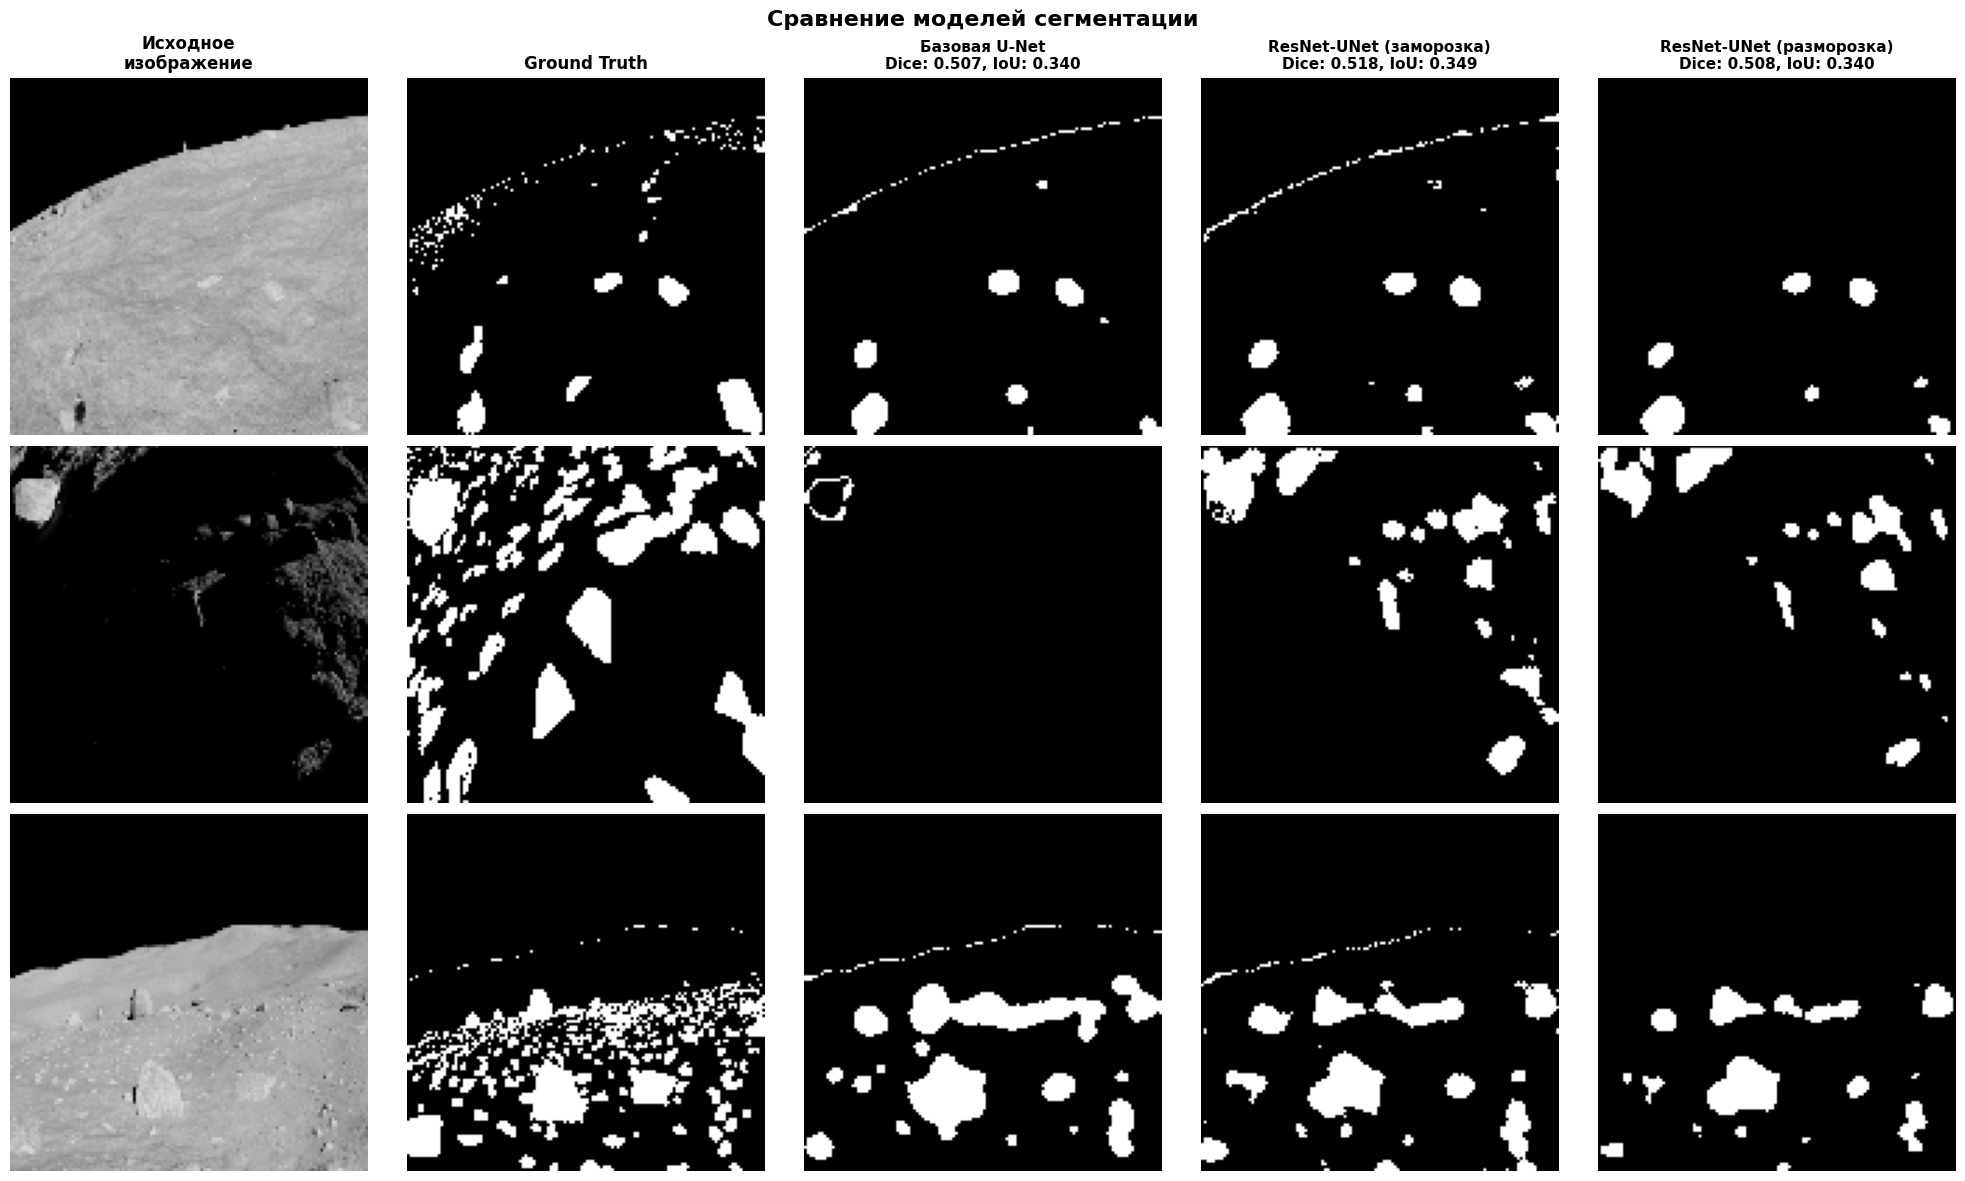

ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ
                  Модель Параметры  Лучшая эпоха Val Dice Val IoU Val Accuracy Train Dice (финал) Val Loss (финал)
           Базовая U-Net     2.47M             1   0.2381  0.1395       0.1395             0.1678           0.7848
 ResNet-UNet (заморозка)     4.66M             1   0.2381  0.1395       0.1395             0.1664           0.8030
ResNet-UNet (разморозка)     4.66M             1   0.2381  0.1395       0.1395             0.1665           0.7720


In [50]:
def compare_all_models(unet_model, resnet_unet_a, resnet_unet_b,
                      val_loader, device, num_samples=3):
    """Сравнение всех трех моделей"""

    models = [unet_model, resnet_unet_a, resnet_unet_b]
    model_names = ["Базовая U-Net", "ResNet-UNet (заморозка)", "ResNet-UNet (разморозка)"]

    # Переводим модели в режим оценки
    for model in models:
        model.eval()

    # Получение батча данных
    images_list = []
    masks_list = []

    for images, masks in val_loader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break

    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    # Предсказания
    predictions = []
    with torch.no_grad():
        for model in models:
            pred = model(images)
            pred = (pred > 0.5).float()
            predictions.append(pred.cpu())

    images = images.cpu()
    masks = masks.cpu()

    # Визуализация
    fig, axes = plt.subplots(num_samples, len(models) + 2, figsize=(20, 4 * num_samples))

    for i in range(num_samples):
        # Исходное изображение
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        if i == 0:
            axes[i, 0].set_title('Исходное\nизображение', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')

        # Истинная маска
        mask_true = masks[i].numpy()
        axes[i, 1].imshow(mask_true, cmap='gray')
        if i == 0:
            axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')

        # Предсказания моделей
        for j, (pred, name) in enumerate(zip(predictions, model_names)):
            mask_pred = pred[i, 0].numpy()

            # Вычисление метрик
            dice = dice_coefficient(pred[i:i+1], masks[i:i+1].unsqueeze(1))
            iou = iou_score(pred[i:i+1], masks[i:i+1].unsqueeze(1))

            axes[i, j + 2].imshow(mask_pred, cmap='gray')
            if i == 0:
                axes[i, j + 2].set_title(f'{name}\nDice: {dice:.3f}, IoU: {iou:.3f}',
                                        fontsize=11, fontweight='bold')
            axes[i, j + 2].axis('off')

    plt.suptitle('Сравнение моделей сегментации', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def create_comparison_table(history_unet, history_resnet_a, history_resnet_b):
    """Создание таблицы сравнения моделей"""

    # Нахождение лучших эпох
    best_epoch_unet = history_unet['val_dice'].index(max(history_unet['val_dice']))
    best_epoch_resnet_a = history_resnet_a['val_dice'].index(max(history_resnet_a['val_dice']))
    best_epoch_resnet_b = history_resnet_b['val_dice'].index(max(history_resnet_b['val_dice']))

    # Создание DataFrame
    comparison_data = {
        'Модель': ['Базовая U-Net', 'ResNet-UNet (заморозка)', 'ResNet-UNet (разморозка)'],
        'Параметры': ['2.47M', '4.66M', '4.66M'],
        'Лучшая эпоха': [best_epoch_unet + 1, best_epoch_resnet_a + 1, best_epoch_resnet_b + 1],
        'Val Dice': [
            max(history_unet['val_dice']),
            max(history_resnet_a['val_dice']),
            max(history_resnet_b['val_dice'])
        ],
        'Val IoU': [
            history_unet['val_iou'][best_epoch_unet],
            history_resnet_a['val_iou'][best_epoch_resnet_a],
            history_resnet_b['val_iou'][best_epoch_resnet_b]
        ],
        'Val Accuracy': [
            history_unet['val_acc'][best_epoch_unet],
            history_resnet_a['val_acc'][best_epoch_resnet_a],
            history_resnet_b['val_acc'][best_epoch_resnet_b]
        ],
        'Train Dice (финал)': [
            history_unet['train_dice'][-1],
            history_resnet_a['train_dice'][-1],
            history_resnet_b['train_dice'][-1]
        ],
        'Val Loss (финал)': [
            history_unet['val_loss'][-1],
            history_resnet_a['val_loss'][-1],
            history_resnet_b['val_loss'][-1]
        ]
    }

    df = pd.DataFrame(comparison_data)

    # Форматирование чисел
    for col in ['Val Dice', 'Val IoU', 'Val Accuracy', 'Train Dice (финал)', 'Val Loss (финал)']:
        df[col] = df[col].apply(lambda x: f'{x:.4f}')

    return df


# Сравнение моделей
compare_all_models(
    trained_unet,
    trained_resnet_unet_a,
    trained_resnet_unet_b,
    val_loader_seg,
    device,
    num_samples=3
)

# Создание таблицы сравнения
comparison_df = create_comparison_table(
    history_unet,
    history_resnet_unet_a,
    history_resnet_unet_b
)

print("="*70)
print("ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

1. Базовая U-Net (2.47M параметров)
Преимущество: Самая простая модель,
Val Dice = 0.2381 (достаточно низкий), Train Dice (0.1678) значительно ниже Val Dice

2. ResNet-UNet с замороженным энкодером (4.66M параметров)
Параметры: На 89% больше чем базовая U-Net, Результат: Точно такие же метрики как у базовой U-Net, Вывод: Предобученный энкодер не помогает, когда заморожен

3. ResNet-UNet с размороженным энкодером (4.66M параметров)
Параметры: Все 4.66M обучаемы, Результат: Точно такие же метрики как у других моделей, Единственное отличие: Val Loss = 0.7720 (лучше на 1.6-4.0%), Вывод: Fine-tuning энкодера не улучшает качество